# I) Import the necessary packages

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

import warnings
warnings.filterwarnings('ignore')

from scipy import stats
from scipy.stats import f_oneway

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler
from imblearn.over_sampling import SMOTE

import os
from pathlib import Path

from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier,
                             BaggingClassifier, AdaBoostClassifier, ExtraTreesClassifier)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.calibration import CalibratedClassifierCV

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, davies_bouldin_score
import scikitplot as skplt
from yellowbrick.model_selection import FeatureImportances

import joblib

import datetime as dt
from datetime import datetime as dt2
from datetime import timedelta as td
from datetime import time as tm

from sklearn.manifold import TSNE

import plotly.offline as pyoff
import plotly.graph_objs as go

import feature_engine
from feature_engine.outliers import Winsorizer

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

from sklearn.pipeline import Pipeline

# II) Get the data

## 1) Load and merge CSV files

In [5]:
customers = pd.read_csv('olist_customers_dataset.csv')
geolocation = pd.read_csv('olist_geolocation_dataset.csv')
items = pd.read_csv('olist_order_items_dataset.csv')
payments = pd.read_csv('olist_order_payments_dataset.csv')
reviews = pd.read_csv('olist_order_reviews_dataset.csv')
orders = pd.read_csv('olist_orders_dataset.csv')
products = pd.read_csv('olist_products_dataset.csv')
sellers = pd.read_csv('olist_sellers_dataset.csv')
translation = pd.read_csv('product_category_name_translation.csv')

In [6]:
tables = {
    'customers': customers,
    'geolocation': geolocation,
    'items': items,
    'payments': payments,
    'reviews': reviews,
    'orders': orders,
    'products': products,
    'sellers': sellers,
    'translation': translation
}

def show_column_names(tables_dict):
    for name, df in tables_dict.items():
        print(df.info())

show_column_names(tables)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-n

In [7]:
def process_data(customers, orders, items, products, translation, sellers, payments, reviews):
    # B1. Gộp customers + orders
    df = pd.merge(orders, customers, on='customer_id', how='left')

    # B2. Gộp với order_items
    df = pd.merge(df, items, on='order_id', how='left')

    # B3. Gộp với products (để lấy product_category_name)
    df = pd.merge(df, products[['product_id', 'product_category_name']], on='product_id', how='left')

    # B4. Gộp với translation (để lấy tên danh mục tiếng Anh)
    df = pd.merge(df, translation, on='product_category_name', how='left')

    # B5. Gộp với sellers
    df = pd.merge(df, sellers, on='seller_id', how='left')

    # B6. Gộp với payments
    df = pd.merge(df, payments[['order_id', 'payment_type']], on='order_id', how='left')

    # B7. Gộp với reviews
    df = pd.merge(df, reviews[['order_id', 'review_score']], on='order_id', how='left')

    # B8. Chọn các cột mong muốn
    cols_to_keep = [
        'customer_id','customer_unique_id','customer_city','customer_state',
        'order_id','order_status','order_purchase_timestamp',
        'order_item_id','product_id','product_category_name_english',
        'price','freight_value',
        'seller_id','seller_city','seller_state',
        'payment_type',
        'review_score'
    ]
    df_final = df[cols_to_keep].drop_duplicates()

    # Tạo cột has_voucher: 1 nếu có voucher, 0 nếu không
    df_final['has_voucher'] = df_final.groupby('order_id')['payment_type'].transform(lambda x: int('voucher' in x.values))

    # Loại bỏ dòng có payment_type là 'voucher' (đã đánh dấu bằng has_voucher rồi)
    df_final = df_final[df_final['payment_type'] != 'voucher']

    # Xoá order_item_id để gom nhóm
    df_final = df_final.drop(columns=['order_item_id'])

    # Gom nhóm theo các cột khác price, freight_value
    cols_to_group = df_final.columns.difference(['price', 'freight_value']).tolist()

    # Gom nhóm và tính tổng
    df_grouped = df_final.groupby(cols_to_group, dropna=False).agg({
        'price': 'sum',
        'freight_value': 'sum'
    }).reset_index()

    # Đếm số dòng trùng (số đơn hàng)
    df_grouped['num_orders'] = df_final.groupby(cols_to_group, dropna=False).size().values
    
    return df_grouped

In [8]:
df_result = process_data(customers, orders, items, products, translation, sellers, payments, reviews)
print(df_result.info())
df_result.head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101761 entries, 0 to 101760
Data columns (total 18 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   customer_city                  101761 non-null  object 
 1   customer_id                    101761 non-null  object 
 2   customer_state                 101761 non-null  object 
 3   customer_unique_id             101761 non-null  object 
 4   has_voucher                    101761 non-null  int64  
 5   order_id                       101761 non-null  object 
 6   order_purchase_timestamp       101761 non-null  object 
 7   order_status                   101761 non-null  object 
 8   payment_type                   101760 non-null  object 
 9   product_category_name_english  99604 non-null   object 
 10  product_id                     101066 non-null  object 
 11  review_score                   100964 non-null  float64
 12  seller_city                   

,customer_city,customer_id,customer_state,customer_unique_id,has_voucher,order_id,order_purchase_timestamp,order_status,payment_type,product_category_name_english,product_id,review_score,seller_city,seller_id,seller_state,price,freight_value,num_orders
0,abadia dos dourados,9e01f714a2b3b8962c222cf2b74c20dc,MG,e1feae9083c4c2895ddf6dc80526a85d,0,50ba38c4dc467baab1ea2c8c7747934d,2018-03-02 21:32:44,delivered,credit_card,cool_stuff,418d480693f2f01e9cf4568db0346d28,5.0,montenegro,12b9676b00f60f3b700e83af21824c0e,RS,199.00,20.63,1
1,abadia dos dourados,a23e3f9a2b656b23b7e52075964b42cd,MG,afddf43a03a9941624ed42c0b2c17280,0,d99e6849f7676dade195f20c26f0eb4f,2017-09-02 22:37:17,delivered,credit_card,sports_leisure,1081ae52311daac87fb54ba8ce4670ac,5.0,sao paulo,4371b634e0efc0e22b09b52907d9d469,SP,120.00,15.59,1
2,abadia dos dourados,f11eb8f0b8b87510a93e3e1aa10b0ade,MG,64ee476500a01beb94df40f97a108c50,0,0a9a43ac5fe59c6c4bee2a8f9b9fcce8,2018-07-02 08:00:35,delivered,boleto,books_general_interest,c1aabbb6f4caec9f5bf7cd80519d6cc0,5.0,rio de janeiro,579891617139df7d8671d373f0669622,RJ,39.90,18.38,1
3,abadiania,576d71ddb21b21763cfedce73b902180,GO,8d76b559181609308fcae630ea64cd61,0,3f1294f87d79b57f5d55ba7b80c3d94f,2018-01-28 14:21:58,delivered,credit_card,small_appliances,0a9b9a871ffaec6c0198334558a6c6a1,4.0,sao paulo,f9244d45189d3a3605499abddeade7d5,SP,949.99,75.53,1
4,abaete,08528824266cd0720658ff01df662b6a,MG,8f7f547488a05660770b51be707eb2a3,0,5525ea8ee9e6150faa9b41dfc4024552,2018-08-20 21:33:48,delivered,credit_card,cool_stuff,3354a4e684f5e7199f9407db70ccd92b,5.0,sao paulo,7a67c85e85bb2ce8582c35f2203ad736,SP,85.99,23.40,1
5,abaete,225634426cfd64638ae97bf60e190f5b,MG,ca1a0307fe782c9125fd9264c92db778,0,ee2b11b5601e9de355fb771525a195ce,2017-11-20 17:08:59,delivered,credit_card,housewares,66fc767a58575873dad11a4c717727dc,4.0,itajai,0bae85eb84b9fb3bd773911e89288d54,SP,54.16,23.25,1
6,abaete,24d97ea7bb12a40f87d701e17017d282,MG,5bd046eccd966d97c4fe06e8d75a64a7,0,74bdc516d1c6a8e16cd1a546ea067c26,2018-03-27 11:00:09,delivered,boleto,stationery,5d136eed606105a39f8cffd4b7978951,5.0,bauru,55bb6fe5bebe5012e2d7d9928e1128ff,SP,47.07,19.32,1
7,abaete,2bf14bf7a1f0610883d264cae6bc4de6,MG,1605eaf5744972f09529a6ce287e9e47,0,902864b6c62e404e8a57ca48c90657e8,2017-07-31 17:48:16,delivered,credit_card,baby,cdce55fb5fbe6b24f00f27364a8afde3,4.0,itatiba,855668e0971d4dfd7bef1b6a4133b41b,SP,65.00,17.70,1
8,abaete,3c46a6771b9833c7571cd2498f548f95,MG,2a19a29632faf108fd680a976034fa3d,0,33d425553bc88c255ddeb68ab933167e,2018-03-05 12:47:02,delivered,boleto,bed_bath_table,9ad75bd7267e5c724cb42c71ac56ca72,4.0,ibitinga,8160255418d5aaa7dbdc9f4c64ebda44,SP,105.90,17.99,1
9,abaete,5371894984937a27cf40c7d20699a786,MG,2d69de392ffdb5def80917230154351d,0,6c12feac9a308e1382d9b19cca7f20b2,2017-05-05 13:48:37,delivered,credit_card,health_beauty,d47821b10559fffaefcf3e57d2b5ff76,4.0,betim,0df3984f9dfb3d49ac6366acbd3bbb85,MG,208.90,12.07,1


## 2) Rename features

In [10]:
df_result.rename(columns={
    'customer_id': 'Customer ID',
    'customer_unique_id': 'Customer Unique ID',
    'customer_city': 'Customer City',
    'customer_state': 'Customer State',
    'order_id': 'Order ID',
    'order_purchase_timestamp': 'Purchase Time',
    'order_status': 'Order Status',
    'payment_type': 'Payment Method',
    'has_voucher': 'Used Voucher',
    'product_id': 'Product ID',
    'product_category_name_english': 'Product Category',
    'price': 'Price',
    'freight_value': 'Shipping Fee',
    'review_score': 'Review Score',
    'seller_id': 'Seller ID',
    'seller_city': 'Seller City',
    'seller_state': 'Seller State',
    'num_orders': 'Num Items'
}, inplace=True)

ordered_cols = [
    'Order ID', 'Purchase Time', 'Order Status',
    'Customer ID', 'Customer Unique ID', 'Customer City', 'Customer State',
    'Product ID', 'Product Category', 'Num Items',
    'Price', 'Shipping Fee',
    'Seller ID', 'Seller City', 'Seller State',
    'Payment Method', 'Used Voucher', 'Review Score'
]

df_result = df_result[ordered_cols]

df_result['Purchase Time'] = pd.to_datetime(df_result['Purchase Time'], errors='coerce')

df_result['Used Voucher'] = df_result['Used Voucher'].map({1: 'Yes', 0: 'No'})

# III) Explore the Data

## 1) Quick glance at the data

In [13]:
full_data = df_result.copy()

In [14]:
full_data['Day'] = full_data['Purchase Time'].dt.day
full_data['Month'] = full_data['Purchase Time'].dt.month
full_data['Year'] = full_data['Purchase Time'].dt.year

In [15]:
full_data.head()

,Order ID,Purchase Time,Order Status,Customer ID,Customer Unique ID,Customer City,Customer State,Product ID,Product Category,Num Items,...,Shipping Fee,Seller ID,Seller City,Seller State,Payment Method,Used Voucher,Review Score,Day,Month,Year
0,50ba38c4dc467baab1ea2c8c7747934d,2018-03-02 21:32:44,delivered,9e01f714a2b3b8962c222cf2b74c20dc,e1feae9083c4c2895ddf6dc80526a85d,abadia dos dourados,MG,418d480693f2f01e9cf4568db0346d28,cool_stuff,1,...,20.63,12b9676b00f60f3b700e83af21824c0e,montenegro,RS,credit_card,No,5.0,2,3,2018
1,d99e6849f7676dade195f20c26f0eb4f,2017-09-02 22:37:17,delivered,a23e3f9a2b656b23b7e52075964b42cd,afddf43a03a9941624ed42c0b2c17280,abadia dos dourados,MG,1081ae52311daac87fb54ba8ce4670ac,sports_leisure,1,...,15.59,4371b634e0efc0e22b09b52907d9d469,sao paulo,SP,credit_card,No,5.0,2,9,2017
2,0a9a43ac5fe59c6c4bee2a8f9b9fcce8,2018-07-02 08:00:35,delivered,f11eb8f0b8b87510a93e3e1aa10b0ade,64ee476500a01beb94df40f97a108c50,abadia dos dourados,MG,c1aabbb6f4caec9f5bf7cd80519d6cc0,books_general_interest,1,...,18.38,579891617139df7d8671d373f0669622,rio de janeiro,RJ,boleto,No,5.0,2,7,2018
3,3f1294f87d79b57f5d55ba7b80c3d94f,2018-01-28 14:21:58,delivered,576d71ddb21b21763cfedce73b902180,8d76b559181609308fcae630ea64cd61,abadiania,GO,0a9b9a871ffaec6c0198334558a6c6a1,small_appliances,1,...,75.53,f9244d45189d3a3605499abddeade7d5,sao paulo,SP,credit_card,No,4.0,28,1,2018
4,5525ea8ee9e6150faa9b41dfc4024552,2018-08-20 21:33:48,delivered,08528824266cd0720658ff01df662b6a,8f7f547488a05660770b51be707eb2a3,abaete,MG,3354a4e684f5e7199f9407db70ccd92b,cool_stuff,1,...,23.40,7a67c85e85bb2ce8582c35f2203ad736,sao paulo,SP,credit_card,No,5.0,20,8,2018


In [16]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101761 entries, 0 to 101760
Data columns (total 21 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   Order ID            101761 non-null  object        
 1   Purchase Time       101761 non-null  datetime64[ns]
 2   Order Status        101761 non-null  object        
 3   Customer ID         101761 non-null  object        
 4   Customer Unique ID  101761 non-null  object        
 5   Customer City       101761 non-null  object        
 6   Customer State      101761 non-null  object        
 7   Product ID          101066 non-null  object        
 8   Product Category    99604 non-null   object        
 9   Num Items           101761 non-null  int64         
 10  Price               101761 non-null  float64       
 11  Shipping Fee        101761 non-null  float64       
 12  Seller ID           101066 non-null  object        
 13  Seller City         101066 no

In [17]:
full_data.describe()

,Purchase Time,Num Items,Price,Shipping Fee,Review Score,Day,Month,Year
count,101761,101761.000000,101761.000000,101761.000000,100964.000000,101761.000000,101761.000000,101761.000000
mean,2017-12-31 08:21:15.410520832,1.100107,132.476854,21.886266,4.060160,15.515826,6.038276,2017.539264
min,2016-09-04 21:15:19,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,2016.000000
25%,2017-09-12 17:22:15,1.000000,44.900000,13.460000,4.000000,8.000000,3.000000,2017.000000
50%,2018-01-18 18:55:18,1.000000,80.380000,16.810000,5.000000,15.000000,6.000000,2018.000000
75%,2018-05-04 15:44:40,1.000000,147.900000,23.230000,5.000000,23.000000,8.000000,2018.000000
max,2018-09-03 14:14:25,20.000000,13440.000000,1794.960000,5.000000,31.000000,12.000000,2018.000000
std,NaN,0.458296,205.667467,20.548591,1.367182,8.668471,3.233895,0.505175


<Axes: >

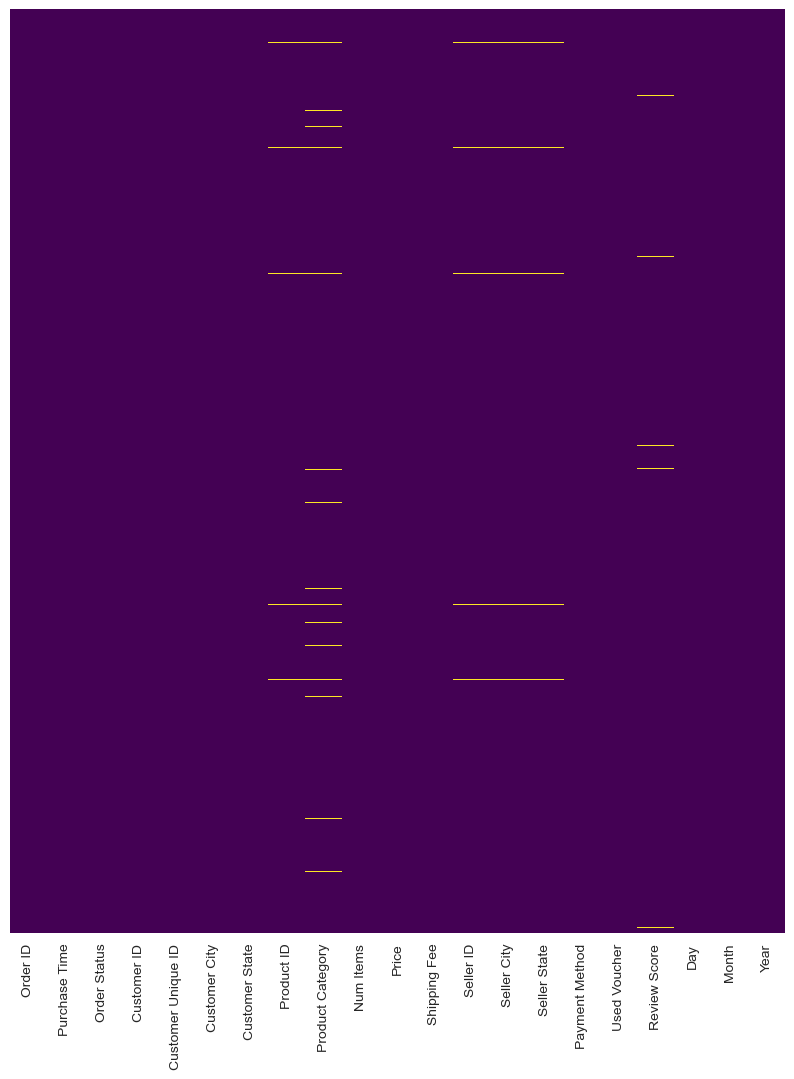

In [18]:
plt.figure(figsize=(10,12))
sns.heatmap(full_data.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [19]:
full_data.nunique()

Order ID              97820
Purchase Time         97268
Order Status              8
Customer ID           97820
Customer Unique ID    94637
Customer City          4110
Customer State           27
Product ID            32576
Product Category         71
Num Items                16
Price                  6946
Shipping Fee           7938
Seller ID              3085
Seller City             609
Seller State             23
Payment Method            4
Used Voucher              2
Review Score              5
Day                      31
Month                    12
Year                      3
dtype: int64

In [20]:
full_data.isnull().sum()

Order ID                 0
Purchase Time            0
Order Status             0
Customer ID              0
Customer Unique ID       0
Customer City            0
Customer State           0
Product ID             695
Product Category      2157
Num Items                0
Price                    0
Shipping Fee             0
Seller ID              695
Seller City            695
Seller State           695
Payment Method           1
Used Voucher             0
Review Score           797
Day                      0
Month                    0
Year                     0
dtype: int64

In [21]:
full_data = full_data.dropna()

## 2) Functions used to explore each feature

In [23]:
#Function that will return the value count and frequency of each observation within a feature
def value_cnt_norm_cal(df,feature):
    ftr_value_cnt = df[feature].value_counts()
    ftr_value_cnt_norm = df[feature].value_counts(normalize=True) * 100
    ftr_value_cnt_concat = pd.concat([ftr_value_cnt, ftr_value_cnt_norm], axis=1)
    ftr_value_cnt_concat.columns = ['Count', 'Frequency (%)']
    return ftr_value_cnt_concat

In [24]:
# function to create display general information about the feature
def gen_info_feat(df,feature):
    match feature:
        case _:
            print('Description:\n{}'.format(df[feature].describe()))
            print('*'*50)
            print('Object type:\n{}'.format(df[feature].dtype))
            print('*'*50)
            value_cnt = value_cnt_norm_cal(df,feature)
            print('Value count:\n{}'.format(value_cnt))

In [25]:
def create_pie_plot(df, feature):
    top_10_features = ['Customer City', 'Customer State', 'Seller City', 'Seller State', 'Product Category']
    if feature in top_10_features:
        top_values = df[feature].value_counts().nlargest(10).index
        df = df[df[feature].isin(top_values)]

    ratio_size = value_cnt_norm_cal(df, feature)
    ratio_size_len = len(ratio_size.index)
    ratio_list = [ratio_size.iloc[i]['Frequency (%)'] for i in range(ratio_size_len)]

    fig, ax = plt.subplots(figsize=(8, 8))
    plt.pie(ratio_list, labels=ratio_size.index, autopct='%1.2f%%',
            startangle=90, wedgeprops={'edgecolor': 'black'})
    plt.title(f'Pie chart of {feature}')
    plt.legend(loc='best')
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

In [26]:
def create_bar_plot(df, feature):
    top_10_features = ['Customer City', 'Customer State', 'Seller City', 'Seller State', 'Product Category']
    if feature in top_10_features:
        top_values = df[feature].value_counts().nlargest(10).index
        df = df[df[feature].isin(top_values)]

    data = value_cnt_norm_cal(df, feature)
    x_labels = data.index
    y_values = data.values[:, 0]

    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(x=x_labels, y=y_values, ax=ax, width=0.5)

    ax.set_xticklabels(labels=x_labels, rotation=45, ha='right')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.title(f'{feature} Count')
    plt.tight_layout()
    plt.show()

In [27]:
# function to create a box plot
def create_box_plot(df,feature):
    match feature:
        case 'Price' | 'Shipping Fee':
            fig, ax = plt.subplots(figsize=(2,8))
            sns.boxplot(y=df[feature])
            plt.title('{} distribution(Boxplot)'.format(feature))
            # suppress scientific notation
            ax.get_yaxis().set_major_formatter(
                matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
            return plt.show()
        case _:
            fig, ax = plt.subplots(figsize=(2,8))
            sns.boxplot(y=df[feature])
            plt.title('{} distribution(Boxplot)'.format(feature))
            return plt.show()

In [28]:
# function to create a histogram plot
def create_hist_plot(df,feature, the_bins=50):
    match feature:
        case 'Price' | 'Shipping Fee':
            fig, ax = plt.subplots(figsize=(18,10))
            sns.histplot(df[feature],bins=the_bins,kde=True)
            # suppress scientific notation
            ax.get_xaxis().set_major_formatter(
                matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
            plt.title('{} distribution'.format(feature))
            return plt.show()
        case _:
            fig, ax = plt.subplots(figsize=(18,10))
            sns.histplot(df[feature],bins=the_bins,kde=True)
            plt.title('{} distribution'.format(feature))
            return plt.show()

## 3) Univariate analysis

### 3.1) Order Status

In [31]:
gen_info_feat(full_data,'Order Status')

Description:
count         98834
unique            7
top       delivered
freq          96793
Name: Order Status, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
              Count  Frequency (%)
Order Status                      
delivered     96793      97.934921
shipped        1009       1.020904
canceled        429       0.434061
invoiced        312       0.315681
processing      282       0.285327
unavailable       7       0.007083
approved          2       0.002024


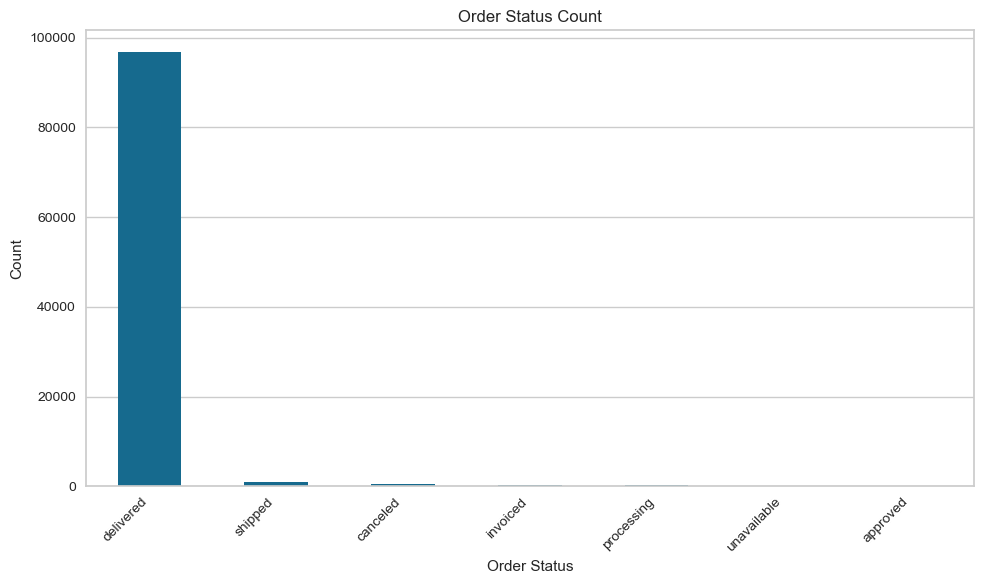

In [32]:
create_bar_plot(full_data,'Order Status')

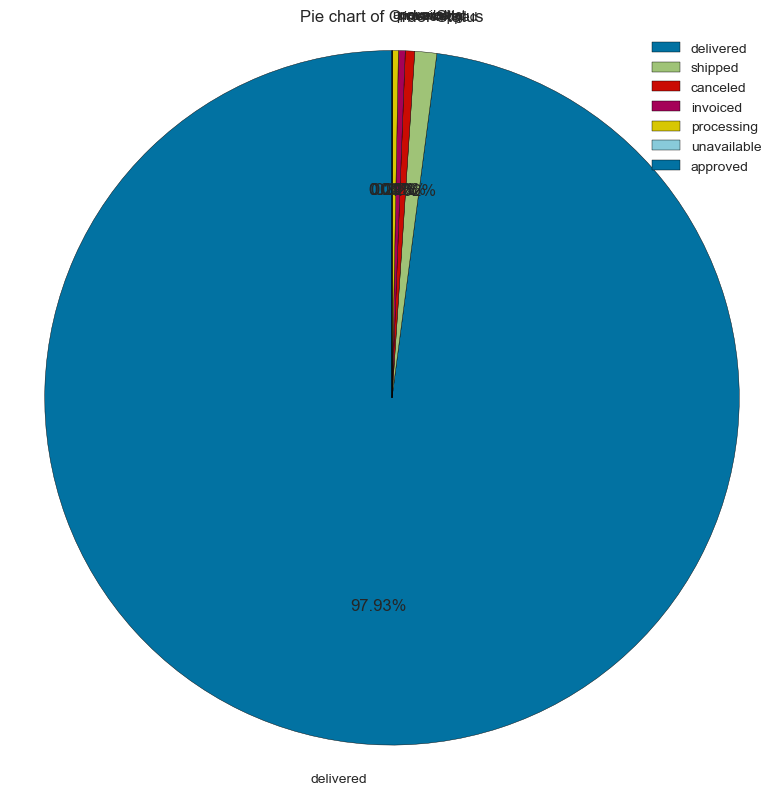

In [33]:
create_pie_plot(full_data,'Order Status')

**Interpretation – `Order Status`**

The `Order Status` column represents the current state of each order and shows a highly imbalanced distribution. Nearly 98% of the orders are marked as `delivered`, indicating that the majority of purchases were successfully completed—suggesting a reliable and efficient order fulfillment process.

Other statuses such as `shipped`, `invoiced`, and `processing` appear in small proportions, indicating that only a few orders are still in transit or under processing. Notably, about 0.43% of orders were marked as `canceled`, which is relatively low but worth monitoring to understand the underlying causes (e.g., customer cancellation, payment issues, or inventory problems).

Extremely rare statuses like `unavailable` and `approved` (each <0.01%) may be outliers or data entry errors. These values should be investigated further before including them in any analytical or machine learning model.

Overall, this column serves as a clear categorical target for classification tasks (e.g., predicting order outcome), but the class imbalance must be addressed appropriately to avoid biased model performance.

### 3.2) Customer City

In [36]:
gen_info_feat(full_data,'Customer City')

Description:
count         98834
unique         4084
top       sao paulo
freq          15481
Name: Customer City, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                     Count  Frequency (%)
Customer City                            
sao paulo            15481      15.663638
rio de janeiro        6760       6.839752
belo horizonte        2762       2.794585
brasilia              2140       2.165247
curitiba              1513       1.530850
...                    ...            ...
lutecia                  1       0.001012
luizlandia do oeste      1       0.001012
luiz alves               1       0.001012
luis correia             1       0.001012
zortea                   1       0.001012

[4084 rows x 2 columns]


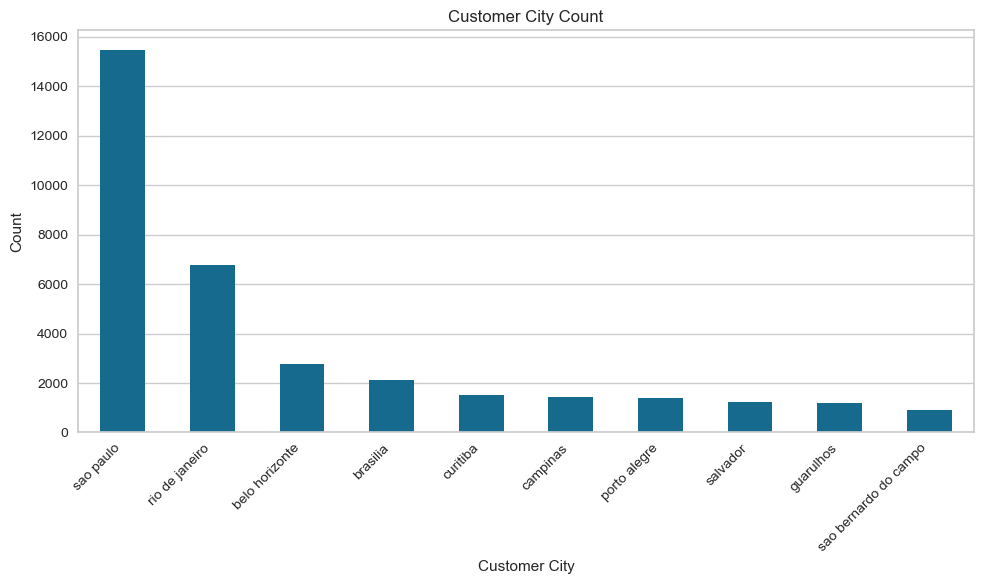

In [37]:
create_bar_plot(full_data,'Customer City')

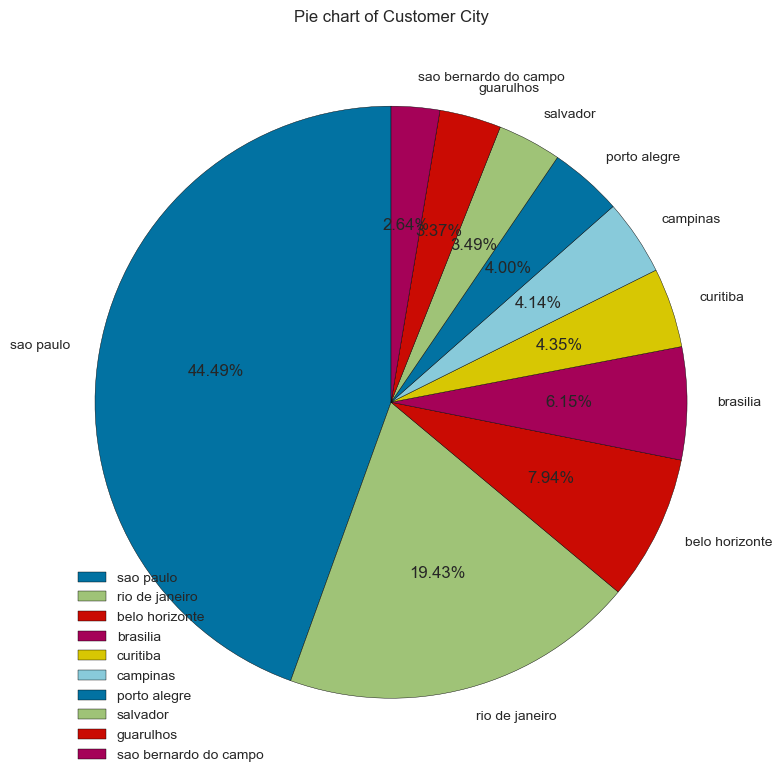

In [38]:
create_pie_plot(full_data,'Customer City')

**Interpretation – `Customer City`**

The `Customer City` column contains the city of each customer and is a high-cardinality categorical feature with **4,084 unique cities** across **98,834 orders**.

The most common city is **São Paulo**, accounting for **15.66%** of all orders, followed by **Rio de Janeiro** (6.84%), **Belo Horizonte**, **Brasilia**, and **Curitiba**. This suggests a strong concentration of customers in major metropolitan areas of Brazil.

### 3.3) Customer State

In [41]:
gen_info_feat(full_data,'Customer State')

Description:
count     98834
unique       27
top          SP
freq      41586
Name: Customer State, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                Count  Frequency (%)
Customer State                      
SP              41586      42.076613
RJ              12679      12.828581
MG              11592      11.728757
RS               5479       5.543639
PR               4988       5.046846
SC               3607       3.649554
BA               3333       3.372321
DF               2148       2.173341
ES               2016       2.039784
GO               2003       2.026631
PE               1624       1.643159
CE               1319       1.334561
PA                954       0.965255
MT                925       0.935913
MA                747       0.755813
MS                713       0.721412
PB                524       0.530182
PI                486       0.491734
RN          

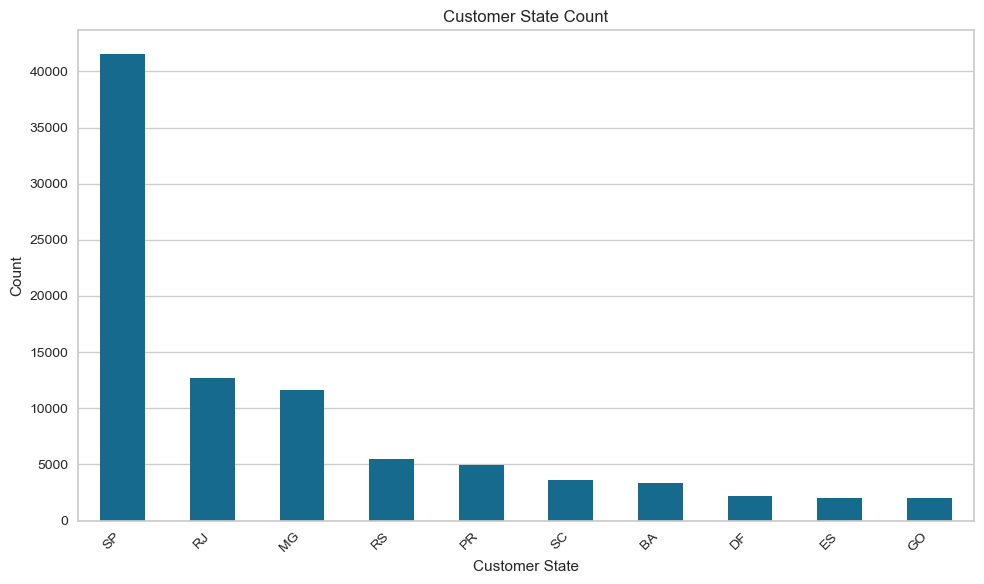

In [42]:
create_bar_plot(full_data,'Customer State')

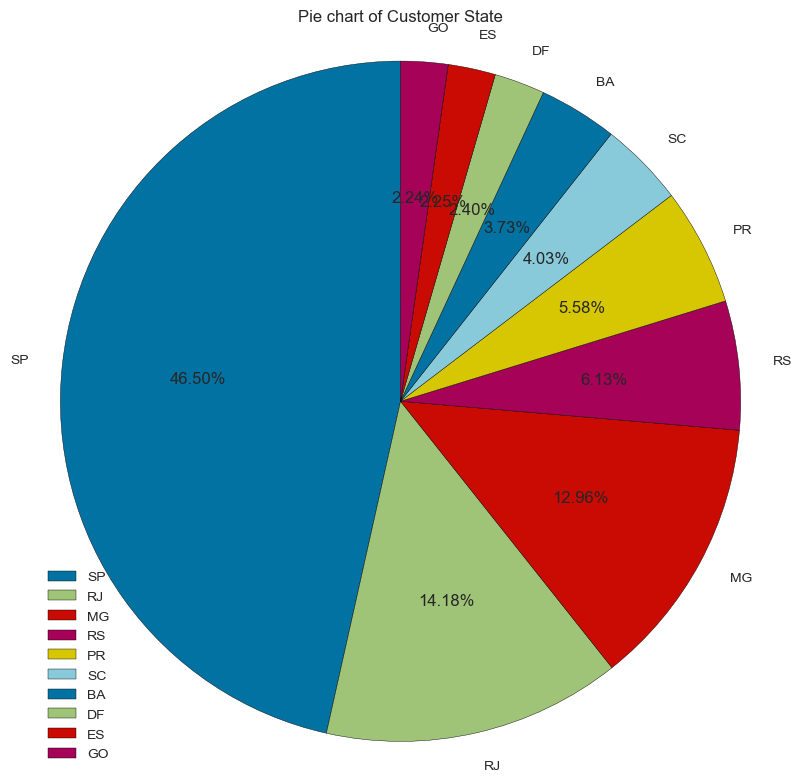

In [43]:
create_pie_plot(full_data,'Customer State')

**Interpretation – `Customer State`**

The `Customer State` column contains abbreviated state codes representing where customers are located, with **27 unique states** across **98,834 records**.

The most represented state is **São Paulo (`SP`)**, contributing to **42.08%** of all orders, followed by **Rio de Janeiro (`RJ`)** an **Minas Gerais (`MG`)** with around **12.8%** and **11.7%**, respectively. These three states alone account for **over 66%** of the total customer base, highlighting a significant concentration of demand in Brazil's most populous and economically active regions.

In contrast, several states such as **Roraima (`RR`)**, **Amapá (`AP`)**, and **Acre (`AC`)** contribute less than **0.1%**, reflecting a long-tail distribution and suggesting limited customer reach or lower e-commerce penetration in those areas.

### 3.4) Product Category

In [46]:
gen_info_feat(full_data,'Product Category')

Description:
count              98834
unique                71
top       bed_bath_table
freq                9940
Name: Product Category, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                           Count  Frequency (%)
Product Category                               
bed_bath_table              9940      10.057268
health_beauty               8860       8.964526
sports_leisure              7706       7.796912
computers_accessories       6779       6.858976
furniture_decor             6635       6.713277
...                          ...            ...
home_comfort_2                22       0.022260
cds_dvds_musicals             12       0.012142
la_cuisine                    12       0.012142
fashion_childrens_clothes      8       0.008094
security_and_services          2       0.002024

[71 rows x 2 columns]


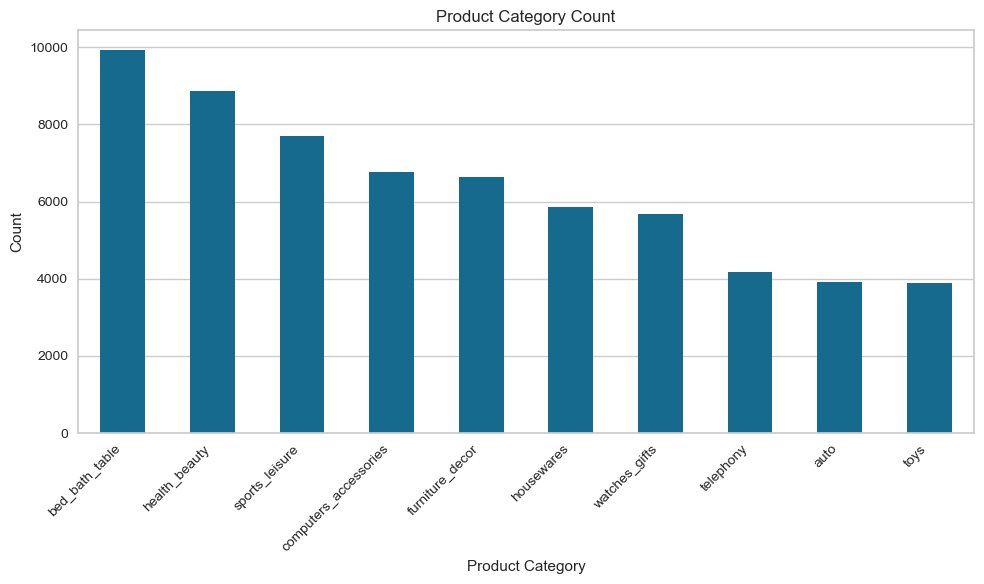

In [47]:
create_bar_plot(full_data,'Product Category')

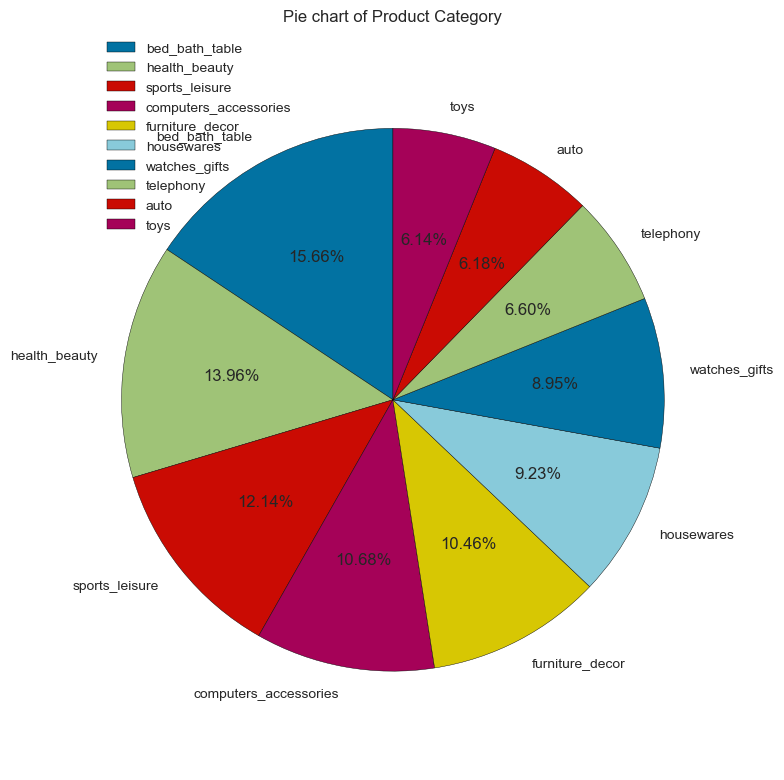

In [48]:
create_pie_plot(full_data,'Product Category')

**Interpretation – `Product Category`**

The `Product Category` column consists of product types, with **71 unique categories** across **98,834 orders**.

The most common product category is **bed_bath_table**, accounting for **10.06%** of all orders. Other notable categories include **health_beauty** (8.96%), **sports_leisure** (7.80%), **computers_accessories** (6.86%), and **furniture_decor** (6.71%). These categories are among the top sellers, suggesting a significant demand for home and personal care items, sports products, and technology accessories.

However, many product categories have extremely low frequencies, with some categories like **security_and_services** and **fashion_childrens_clothes** contributing less than **0.01%**. This indicates that certain products are either niche or have very limited sales.

### 3.5) Seller City

In [51]:
gen_info_feat(full_data,'Seller City')

Description:
count         98834
unique          602
top       sao paulo
freq          24435
Name: Seller City, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                Count  Frequency (%)
Seller City                         
sao paulo       24435      24.723273
ibitinga         6964       7.046158
curitiba         2713       2.745007
santo andre      2667       2.698464
belo horizonte   2310       2.337252
...               ...            ...
pitangueiras        1       0.001012
sbc                 1       0.001012
santa cecilia       1       0.001012
santa catarina      1       0.001012
ronda alta          1       0.001012

[602 rows x 2 columns]


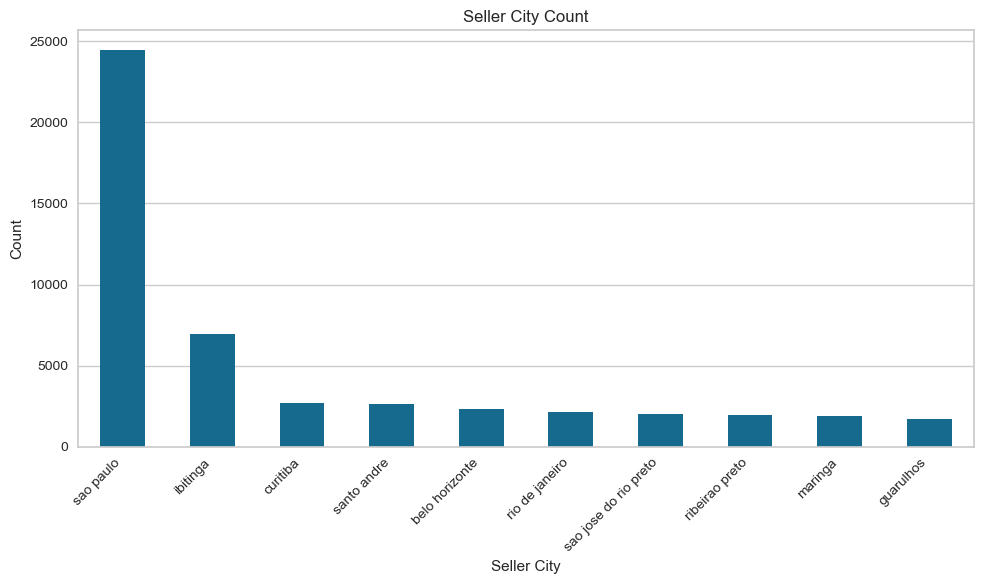

In [52]:
create_bar_plot(full_data,'Seller City')

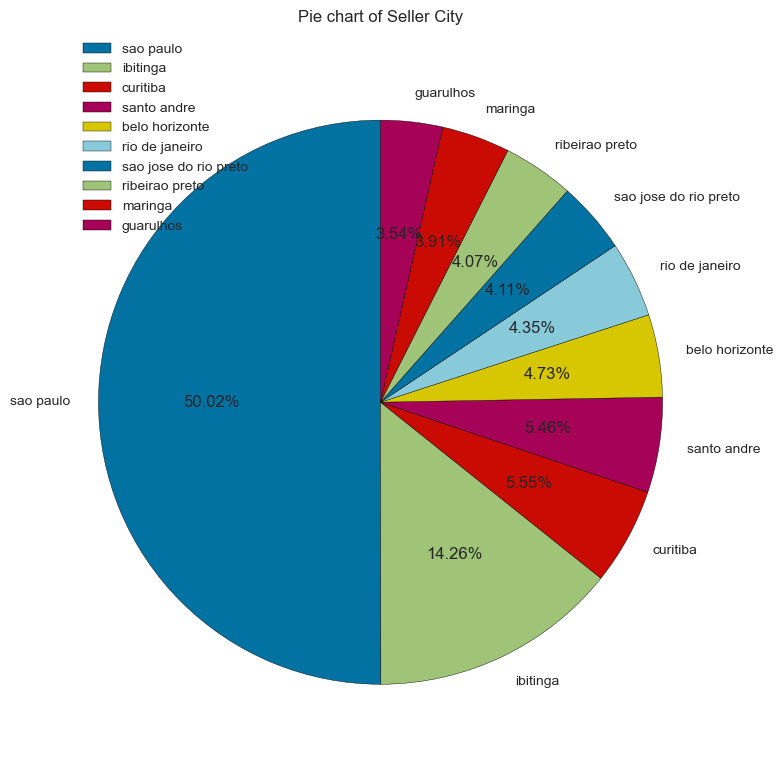

In [53]:
create_pie_plot(full_data,'Seller City')

**Interpretation – `Seller City`**

The `Seller City` column represents the cities where sellers are located, with **602 unique cities** across **98,834 orders**.

The most frequent seller city is **São Paulo**, contributing to **24.72%** of all orders, followed by **Ibitinga** (7.05%), **Curitiba** (2.75%), **Santo André** (2.70%), and **Belo Horizonte** (2.34%). This distribution indicates that a significant proportion of sellers are located in large, well-connected cities, particularly São Paulo, which is a major hub for commerce in Brazil.

There is also a long tail of cities with very low frequencies. Many cities like **Pitangueiras**, **SBC**, and **Santa Cecília** appear only once, making up a very small portion of the dataset (less than **0.1%** each). This suggests that the platform serves a large and geographically diverse seller base, but with varying levels of sales concentration.

### 3.6) Seller State

In [56]:
gen_info_feat(full_data,'Seller State')

Description:
count     98834
unique       23
top          SP
freq      70159
Name: Seller State, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
              Count  Frequency (%)
Seller State                      
SP            70159      70.986705
MG             7762       7.853573
PR             7702       7.792865
RJ             4259       4.309246
SC             3658       3.701155
RS             1947       1.969970
DF              806       0.815509
BA              564       0.570654
GO              464       0.469474
PE              402       0.406743
MA              392       0.396625
ES              311       0.314669
MT              140       0.141652
CE               88       0.089038
RN               53       0.053625
MS               47       0.047554
PB               33       0.033389
RO               14       0.014165
PI               12       0.012142
SE                9

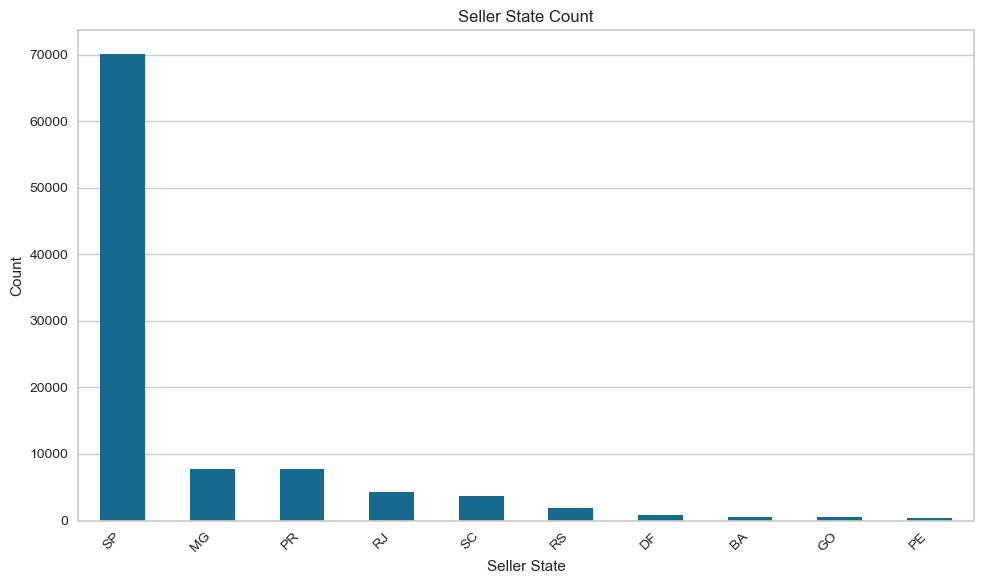

In [57]:
create_bar_plot(full_data,'Seller State')

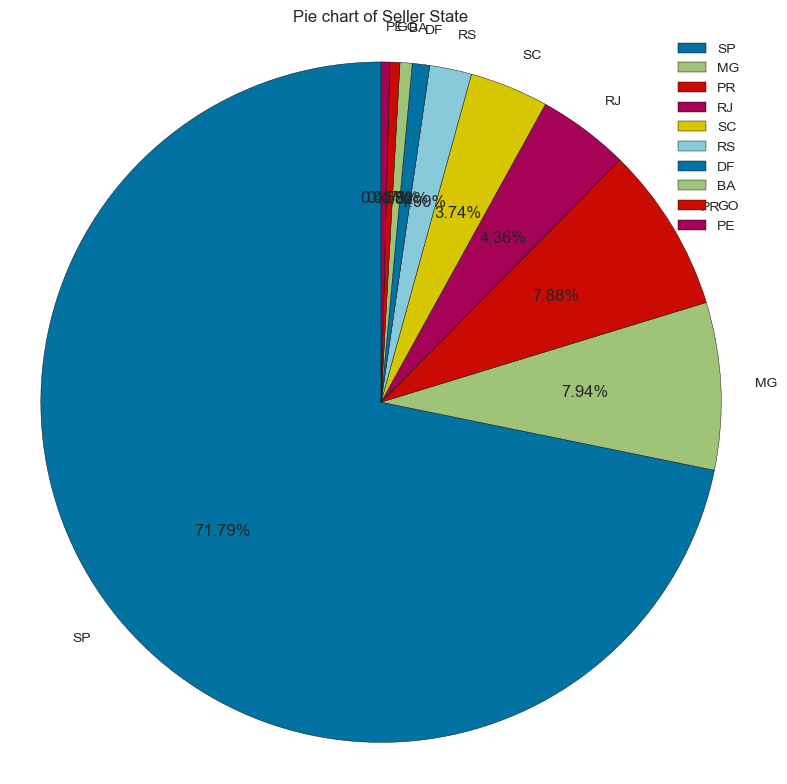

In [58]:
create_pie_plot(full_data,'Seller State')

**Interpretation – `Seller State`**

The `Seller State` column represents the states in which sellers are located, with **23 unique states** across **98,834 orders**.

The state with the highest number of sellers is **São Paulo (`SP`)**, contributing to **70.99%** of all orders, followed by **Minas Gerais (`MG`)** (7.85%), **Paraná (`PR`)** (7.79%), and **Rio de Janeiro (`RJ`)** (4.31%). This indicates that São Paulo is by far the dominant state for sellers, with a significantly higher proportion of the total seller base compared to other regions.

Many other states have much lower frequencies, with states like **Acre (`AC`)**, **Pará (`PA`)**, and **Sergipe (`SE`)** contributing less than **0.01%**. These low-frequency values suggest that the platform has limited seller engagement or lower market penetration in certain regions.

### 3.7) Payment Method

In [61]:
gen_info_feat(full_data,'Payment Method')

Description:
count           98834
unique              3
top       credit_card
freq            77382
Name: Payment Method, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                Count  Frequency (%)
Payment Method                      
credit_card     77382      78.294919
boleto          19905      20.139830
debit_card       1547       1.565251


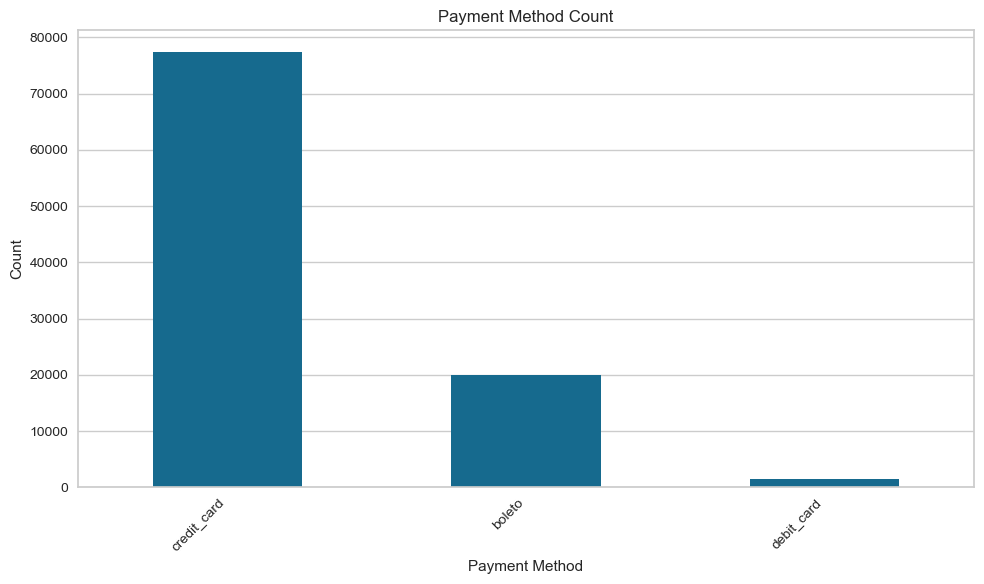

In [62]:
create_bar_plot(full_data,'Payment Method')

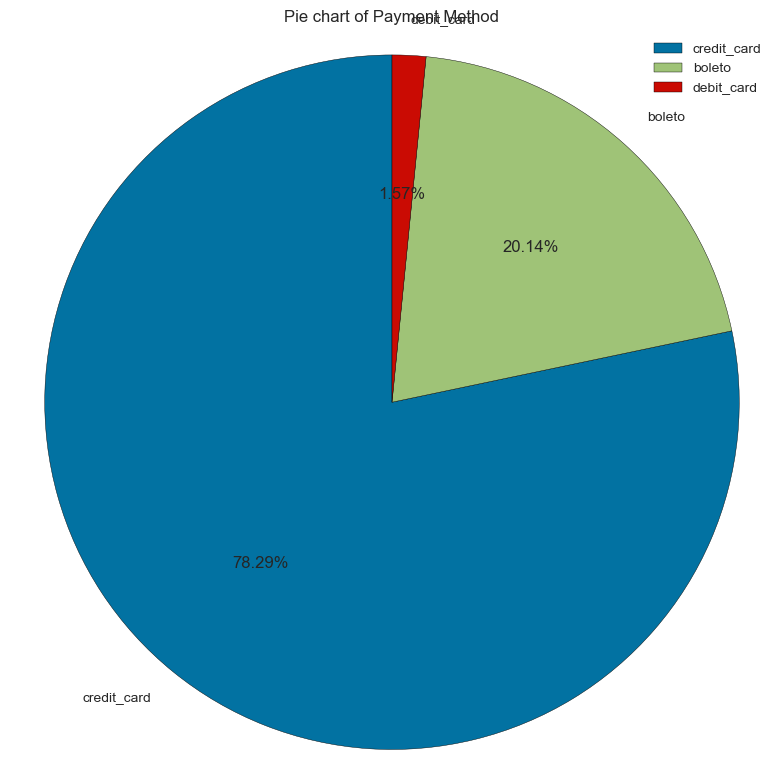

In [63]:
create_pie_plot(full_data,'Payment Method')

**Interpretation – `Payment Method`**

The `Payment Method` column represents the type of payment used by customers for their orders, with **3 unique payment methods** across **98,834 orders**.

The most popular payment method is **credit card**, accounting for **78.29%** of all orders. This suggests that credit cards are the dominant payment option on the platform. The second most frequent payment method is **boleto** (a Brazilian payment method), making up **20.14%** of the orders, while **debit card** is the least used payment method, contributing only **1.57%**.

### 3.8) Used Voucher

In [66]:
gen_info_feat(full_data,'Used Voucher')

Description:
count     98834
unique        2
top          No
freq      96566
Name: Used Voucher, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
              Count  Frequency (%)
Used Voucher                      
No            96566      97.705243
Yes            2268       2.294757


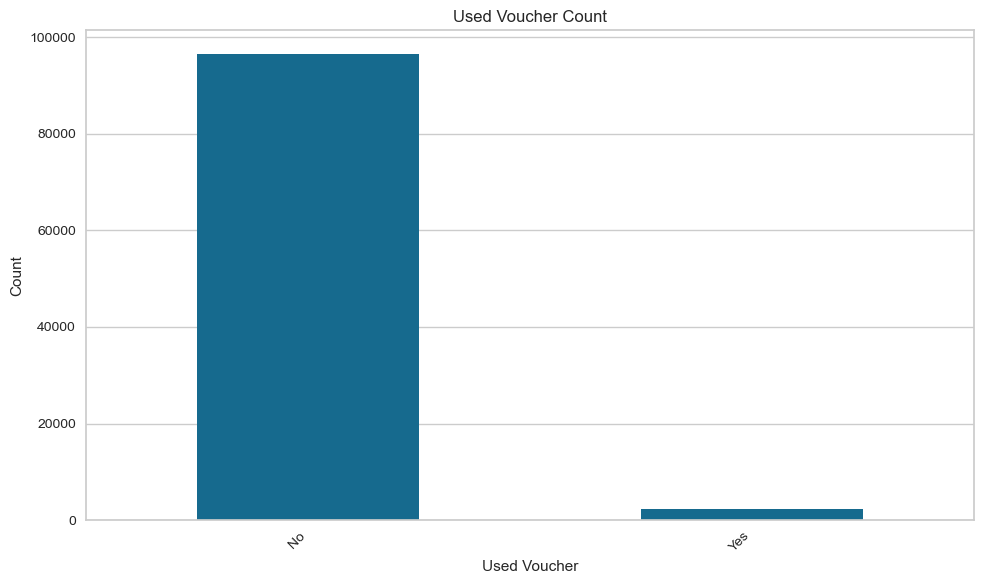

In [67]:
create_bar_plot(full_data,'Used Voucher')

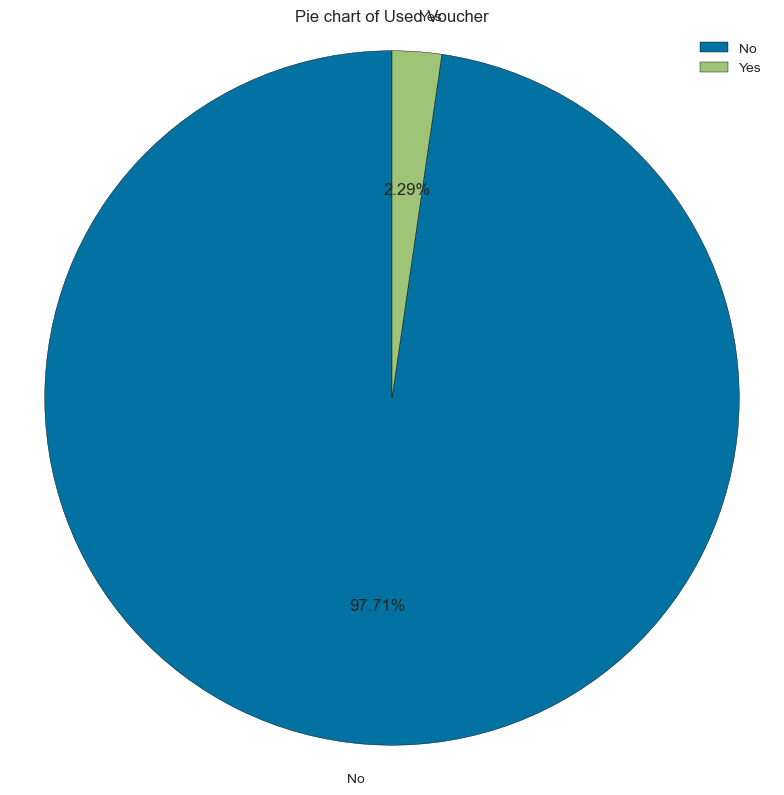

In [68]:
create_pie_plot(full_data,'Used Voucher')

**Interpretation – `Used Voucher`**

The `Used Voucher` column indicates whether a customer used a voucher during their purchase, with **2 unique values** across **98,834 orders**.

The vast majority of orders, **97.71%**, did not use a voucher (`No`), while only **2.29%** of orders involved the use of a voucher (`Yes`). This suggests that vouchers are a relatively rare feature in the purchasing behavior of customers on this platform.

### 3.9) Day

In [71]:
gen_info_feat(full_data,'Day')

Description:
count    98834.000000
mean        15.526347
std          8.667736
min          1.000000
25%          8.000000
50%         16.000000
75%         23.000000
max         31.000000
Name: Day, dtype: float64
**************************************************
Object type:
int32
**************************************************
Value count:
     Count  Frequency (%)
Day                      
24    3910       3.956128
16    3591       3.633365
15    3487       3.528138
4     3464       3.504867
5     3431       3.471477
6     3416       3.456300
18    3406       3.446182
14    3372       3.411781
19    3349       3.388510
7     3317       3.356133
8     3302       3.340956
26    3298       3.336908
25    3287       3.325779
13    3270       3.308578
11    3249       3.287330
3     3244       3.282271
20    3235       3.273165
9     3231       3.269118
17    3178       3.215493
22    3175       3.212457
12    3172       3.209422
2     3165       3.202339
23    3122       3.158832
1

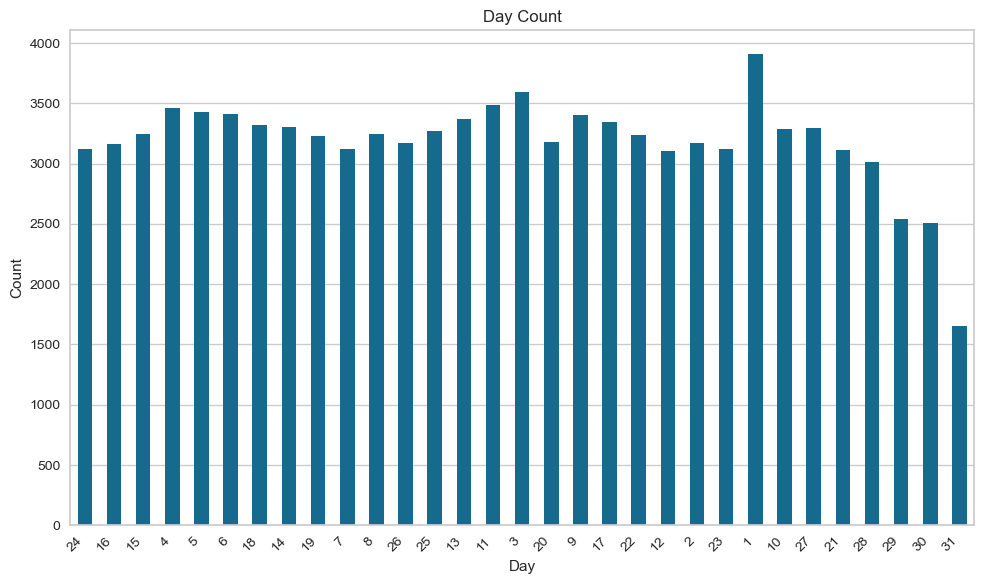

In [72]:
create_bar_plot(full_data,'Day')

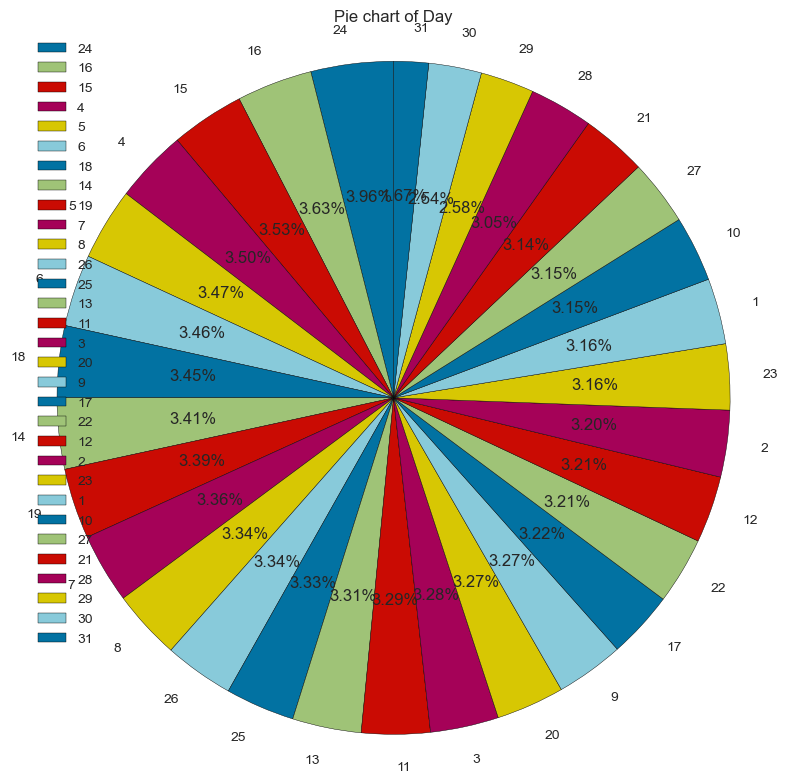

In [73]:
create_pie_plot(full_data,'Day')

**Interpretation – `Day`**

The `Day` column represents the day of the month when an order was placed. The data consists of **98,834 records** with values ranging from **1 to 31**. The column is of type `int32`, and here is a statistical summary:

- **Mean**: 15.53
- **Standard Deviation**: 8.67
- **Minimum Value**: 1
- **Maximum Value**: 31
- **25th Percentile**: 8
- **50th Percentile (Median)**: 16
- **75th Percentile**: 23

From the **value count**, we can see that the most frequent days for orders are:
- **Day 24**: 3.96% of orders
- **Day 16**: 3.63% of orders
- **Day 15**: 3.53% of orders
- The distribution appears to be relatively spread out across the days of the month, with no single day dominating.

### 3.10) Month

In [76]:
gen_info_feat(full_data,'Month')

Description:
count    98834.000000
mean         6.039086
std          3.222428
min          1.000000
25%          3.000000
50%          6.000000
75%          8.000000
max         12.000000
Name: Month, dtype: float64
**************************************************
Object type:
int32
**************************************************
Value count:
       Count  Frequency (%)
Month                      
8      10878      11.006334
5      10590      10.714936
7      10298      10.419491
3       9744       9.858955
6       9471       9.582735
4       9321       9.430965
2       8348       8.446486
1       7940       8.033673
11      7525       7.613777
12      5552       5.617500
10      4927       4.985127
9       4240       4.290022


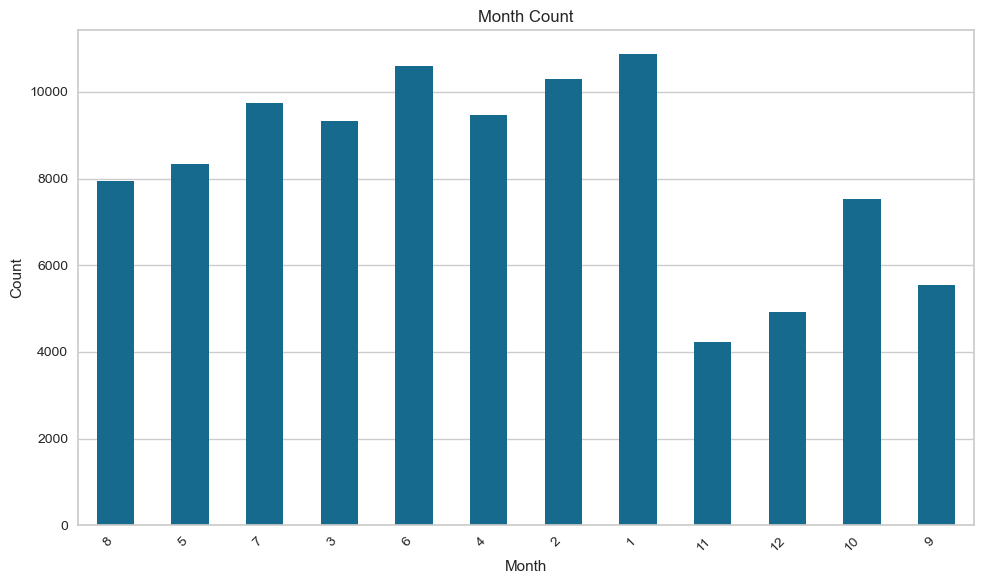

In [77]:
create_bar_plot(full_data,'Month')

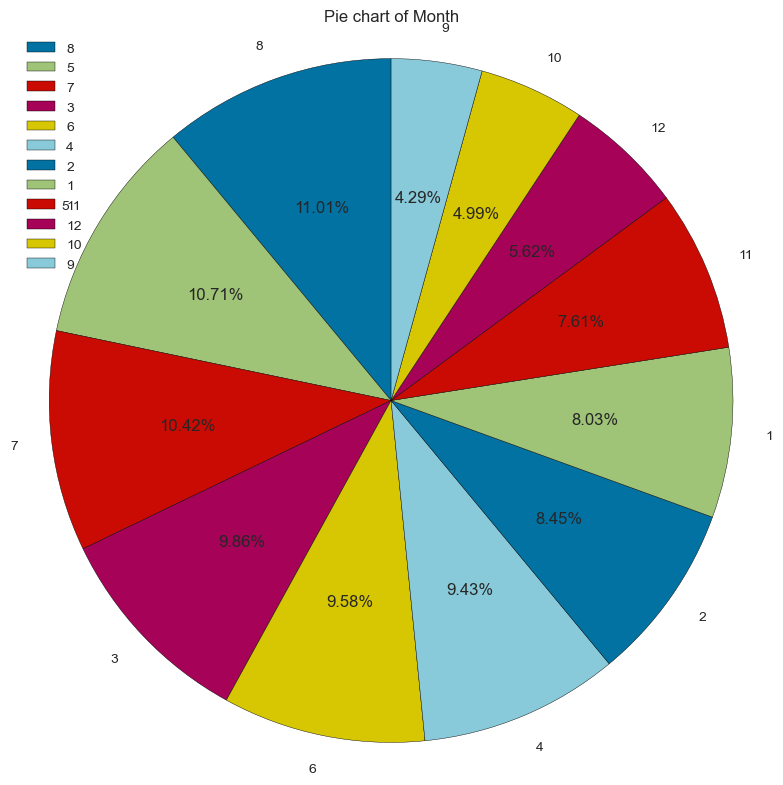

In [78]:
create_pie_plot(full_data,'Month')

**Interpretation – `Month`**

The `Month` column indicates the month of the year when an order was placed. The data consists of **98,834 records** with values ranging from **1 (January)** to **12 (December)**. The column is of type `int32`, and here is a statistical summary:

- **Mean**: 6.04
- **Standard Deviation**: 3.22
- **Minimum Value**: 1 (January)
- **Maximum Value**: 12 (December)
- **25th Percentile**: 3 (March)
- **50th Percentile (Median)**: 6 (June)
- **75th Percentile**: 8 (August)

From the **value count**, we observe the following months with the highest frequency:
- **Month 8 (August)**: 11.01% of orders
- **Month 5 (May)**: 10.71% of orders
- **Month 7 (July)**: 10.42% of orders
- **Month 3 (March)**: 9.86% of orders
- **Month 6 (June)**: 9.58% of orders

### 3.11) Year

In [81]:
gen_info_feat(full_data,'Year')

Description:
count    98834.000000
mean      2017.543517
std          0.504543
min       2016.000000
25%       2017.000000
50%       2018.000000
75%       2018.000000
max       2018.000000
Name: Year, dtype: float64
**************************************************
Object type:
int32
**************************************************
Value count:
      Count  Frequency (%)
Year                      
2018  54037      54.674505
2017  44478      45.002732
2016    319       0.322763


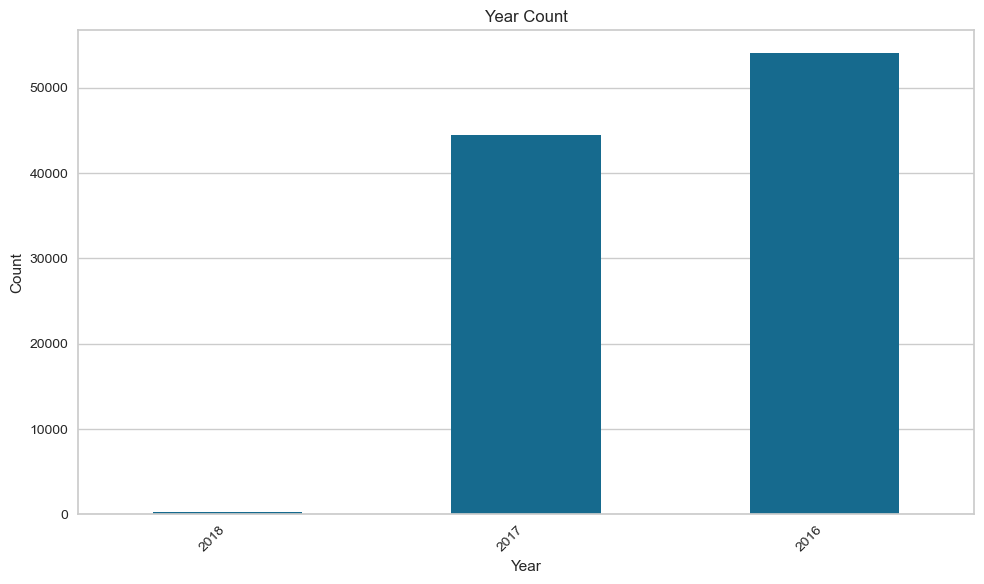

In [82]:
create_bar_plot(full_data,'Year')

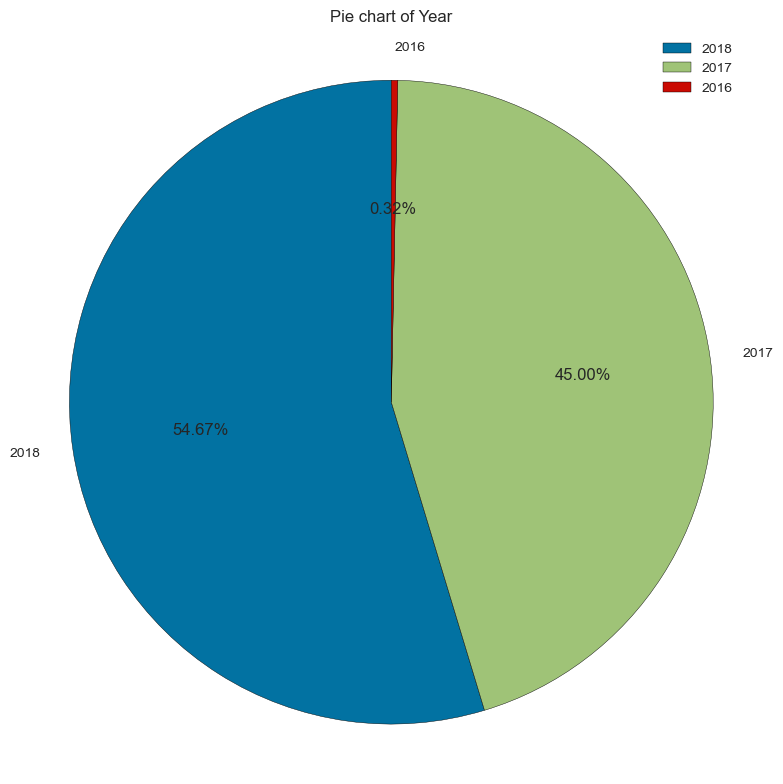

In [83]:
create_pie_plot(full_data,'Year')

**Interpretation – `Year`**

The `Year` column represents the year when an order was placed. The data consists of **98,834 records** and contains values of **2016**, **2017**, and **2018**. The column is of type `int32`, and here is a statistical summary:

- **Mean**: 2017.54
- **Standard Deviation**: 0.50
- **Minimum Value**: 2016
- **Maximum Value**: 2018
- **25th Percentile**: 2017
- **50th Percentile (Median)**: 2018
- **75th Percentile**: 2018

From the **value count**, we observe the following distribution of years:
- **2018**: 54.67% of orders
- **2017**: 45.00% of orders
- **2016**: 0.32% of orders

### 3.12) Num Items

In [86]:
gen_info_feat(full_data,'Num Items')

Description:
count    98834.000000
mean         1.100168
std          0.455038
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         20.000000
Name: Num Items, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
           Count  Frequency (%)
Num Items                      
1          91964      93.048951
2           5221       5.282595
3            916       0.926807
4            380       0.384483
6            167       0.168970
5            164       0.165935
10             5       0.005059
7              4       0.004047
12             2       0.002024
9              2       0.002024
15             2       0.002024
14             2       0.002024
8              2       0.002024
11             1       0.001012
13             1       0.001012
20             1       0.001012


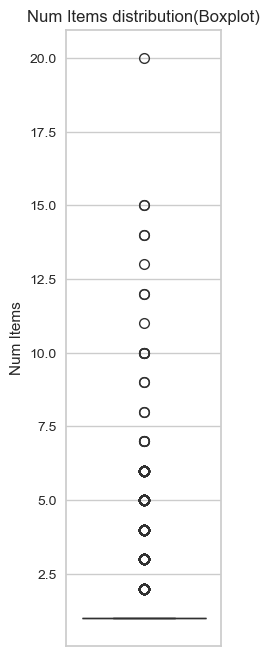

In [87]:
create_box_plot(full_data,'Num Items')

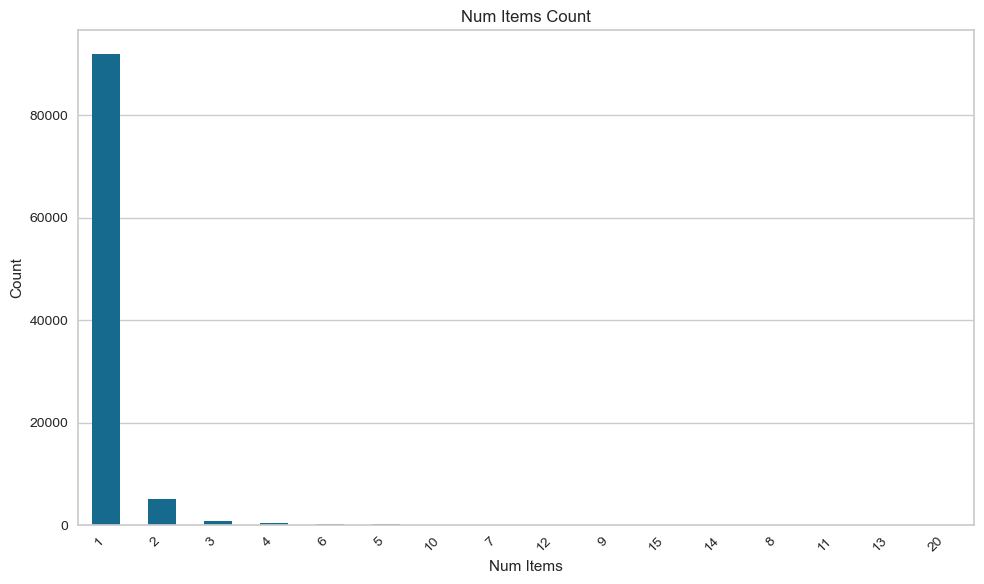

In [88]:
create_bar_plot(full_data,'Num Items')

**Interpretation – `Num Items`**

The `Num Items` column represents the number of items in each order. The data contains **98,834 records** with values ranging from **1** to **20**. This column is of type `int64`, and here is a statistical summary:

- **Mean**: 1.10
- **Standard Deviation**: 0.46
- **Minimum Value**: 1
- **Maximum Value**: 20
- **25th Percentile**: 1
- **50th Percentile (Median)**: 1
- **75th Percentile**: 1

From the **value count**, we observe the following distribution of the number of items in orders:
- **1 item**: 93.05% of orders
- **2 items**: 5.28% of orders
- **3 items**: 0.93% of orders
- **4 items**: 0.38% of orders
- **6 items**: 0.17% of orders
- Other higher values (5, 7, 10, etc.) appear with very low frequencies.

- The overwhelming majority of orders contain **1 item**, which indicates that most customers are placing single-item orders.
- The **mean** and **median** of `1` suggest that **single-item orders** are the norm, while multi-item orders are less common.
- The presence of higher values (e.g., **20 items**) is rare, and may represent special or bulk purchases.

### 3.13) Review Score

In [91]:
full_data['Review Score'] = full_data['Review Score'].astype(int)

In [92]:
gen_info_feat(full_data,'Review Score')

Description:
count    98834.000000
mean         4.078819
std          1.351202
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: Review Score, dtype: float64
**************************************************
Object type:
int32
**************************************************
Value count:
              Count  Frequency (%)
Review Score                      
5             56866      57.536880
4             19015      19.239331
1             11435      11.569905
3              8265       8.362507
2              3253       3.291377


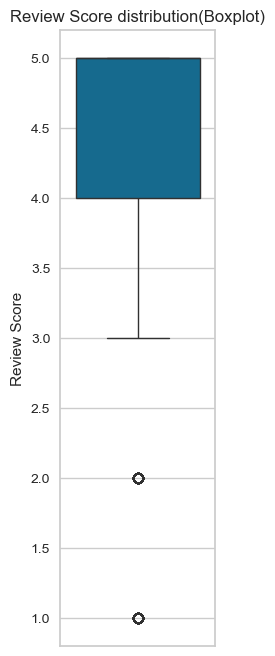

In [93]:
create_box_plot(full_data,'Review Score')

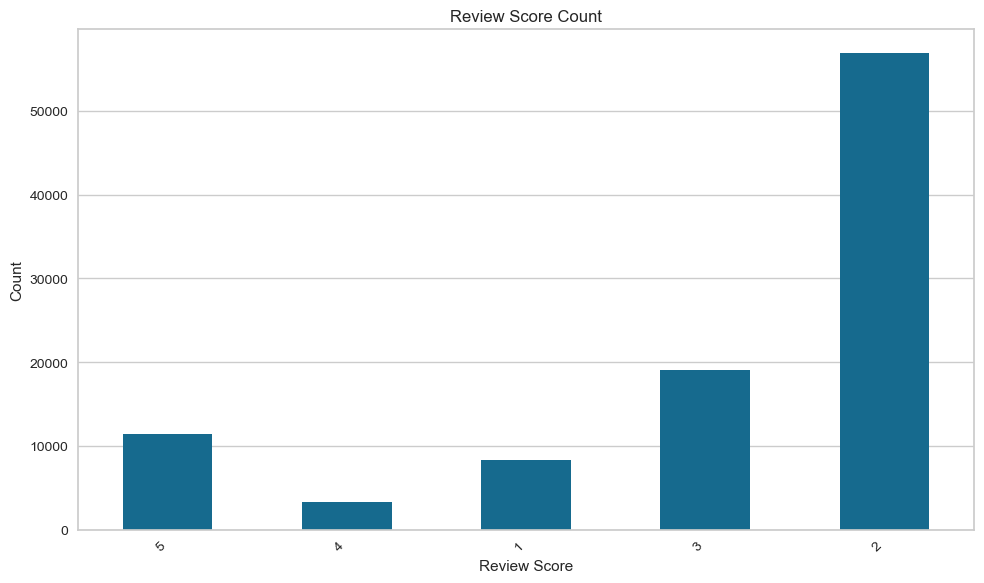

In [94]:
create_bar_plot(full_data,'Review Score')

**Interpretation – `Review Score`**

The `Review Score` column represents the ratings given by customers on a scale from **1 to 5**. The data contains **98,834 records**, and the column is of type `int32`. Here is a statistical summary:

- **Mean**: 4.08
- **Standard Deviation**: 1.35
- **Minimum Value**: 1
- **Maximum Value**: 5
- **25th Percentile**: 4
- **50th Percentile (Median)**: 5
- **75th Percentile**: 5

From the **value count**, we observe the following distribution of review scores:
- **5 stars**: 57.54% of reviews
- **4 stars**: 19.24% of reviews
- **1 star**: 11.57% of reviews
- **3 stars**: 8.36% of reviews
- **2 stars**: 3.29% of reviews

- A majority of reviews (**57.54%**) give a **5-star** rating, which suggests a high level of customer satisfaction with the products or services.
- The **mean score** of 4.08 indicates that, on average, customers rate their experiences positively, with many reviews being closer to 5.
- A significant portion of reviews (**11.57%**) still provide a **1-star** rating, which may signal issues with product quality, customer service, or fulfillment that need further investigation.
- The **median** and **75th percentile** are both **5**, reinforcing the notion of a generally positive review trend.

### 3.14) Price

In [97]:
gen_info_feat(full_data,'Price')

Description:
count    98834.000000
mean       133.329441
std        204.801538
min          0.850000
25%         45.000000
50%         82.890000
75%        148.697500
max      13440.000000
Name: Price, dtype: float64
**************************************************
Object type:
float64
**************************************************
Value count:
         Count  Frequency (%)
Price                        
59.90     1817       1.838436
69.90     1684       1.703867
49.90     1469       1.486331
89.90     1351       1.366939
99.90     1265       1.279924
...        ...            ...
1117.80      1       0.001012
2.99         1       0.001012
185.40       1       0.001012
34.76        1       0.001012
123.40       1       0.001012

[6830 rows x 2 columns]


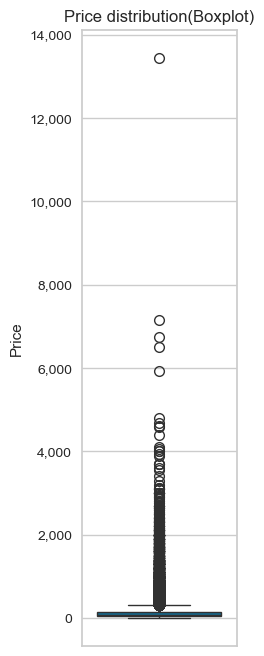

In [98]:
create_box_plot(full_data,'Price')

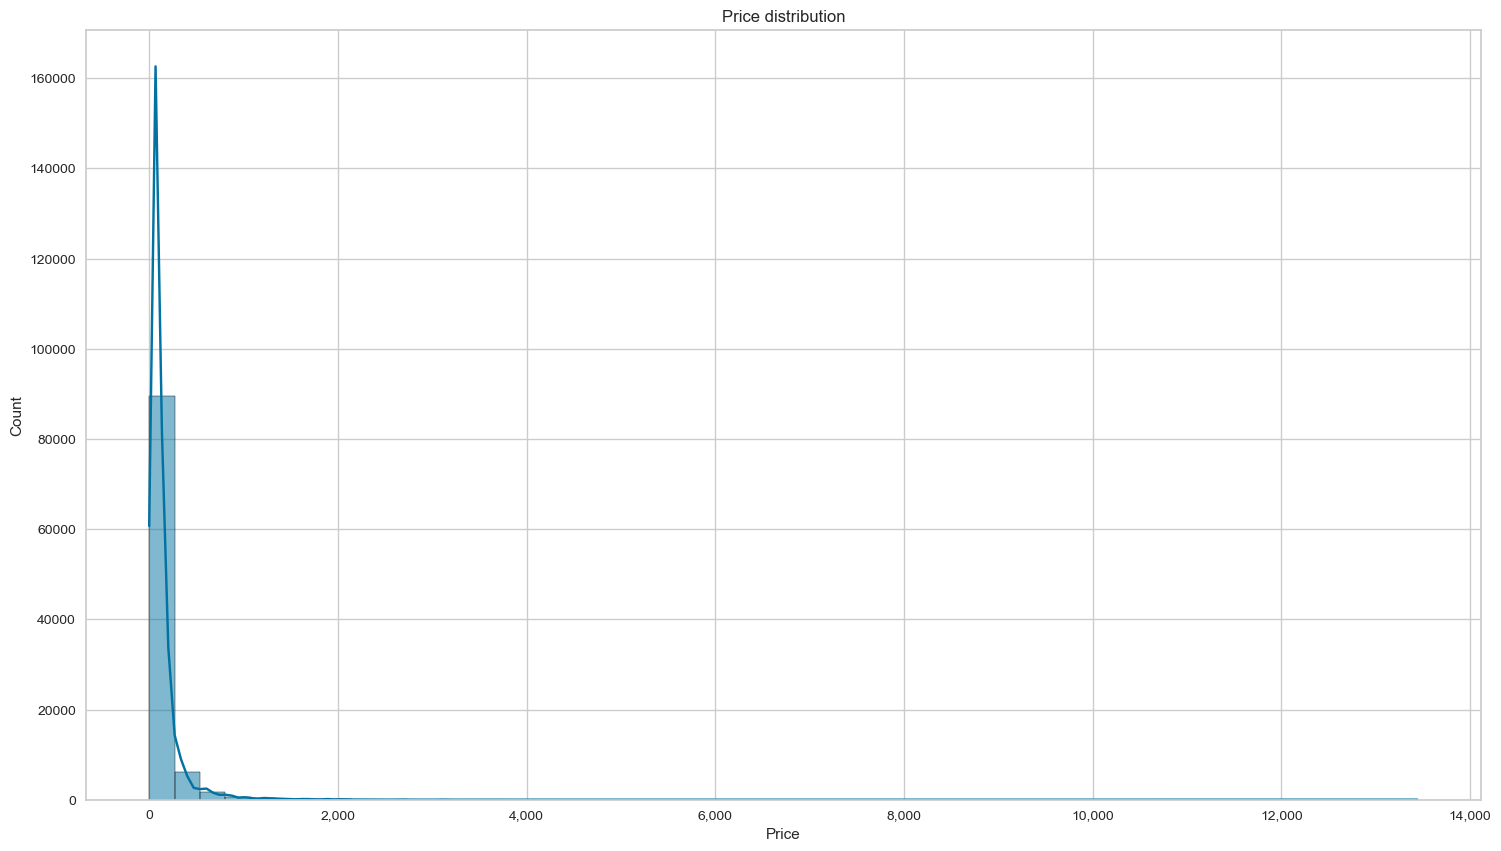

In [99]:
create_hist_plot(full_data,'Price')

**Interpretation – `Price`**

The `Price` column represents the price of items in the dataset. The data contains **98,834 records**, and the column is of type `float64`. Here is a statistical summary:

- **Mean**: 133.33
- **Standard Deviation**: 204.80
- **Minimum Price**: 0.85
- **Maximum Price**: 13,440.00
- **25th Percentile**: 45.00
- **50th Percentile (Median)**: 82.89
- **75th Percentile**: 148.70

From the **value count**, we observe the following prices with notable frequencies:
- **59.90**: 1.84% of the records
- **69.90**: 1.70% of the records
- **49.90**: 1.49% of the records
- **89.90**: 1.37% of the records
- **99.90**: 1.28% of the records

- The **mean price** of 133.33 indicates that most products tend to fall within a higher price range, but there is a large variation due to the wide spread in the data.
- The **standard deviation** of 204.80 is high, indicating significant price variability. Some products are priced as low as **0.85**, while others are priced at **13,440.00**.
- The **median price** of 82.89 suggests that half of the products are priced below this value, pointing to a skewed distribution where many items are priced lower, but there are a few high-ticket items pulling the mean up.

### 3.15) Shipping Fee

In [102]:
gen_info_feat(full_data,'Shipping Fee')

Description:
count    98834.000000
mean        22.063727
std         20.554688
min          0.000000
25%         13.552500
50%         16.920000
75%         23.310000
max       1794.960000
Name: Shipping Fee, dtype: float64
**************************************************
Object type:
float64
**************************************************
Value count:
              Count  Frequency (%)
Shipping Fee                      
15.10          2921       2.955461
7.78           1846       1.867778
14.10          1498       1.515673
11.85          1464       1.481272
18.23          1221       1.235405
...             ...            ...
99.52             1       0.001012
60.32             1       0.001012
42.35             1       0.001012
76.49             1       0.001012
40.67             1       0.001012

[7878 rows x 2 columns]


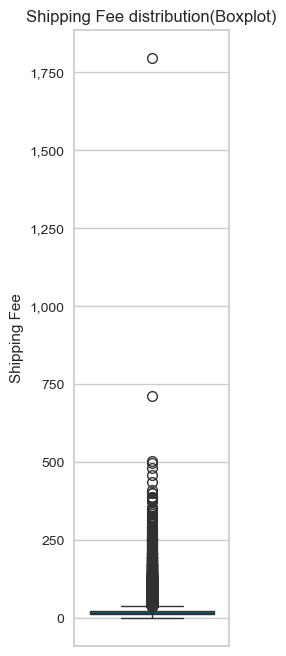

In [103]:
create_box_plot(full_data,'Shipping Fee')

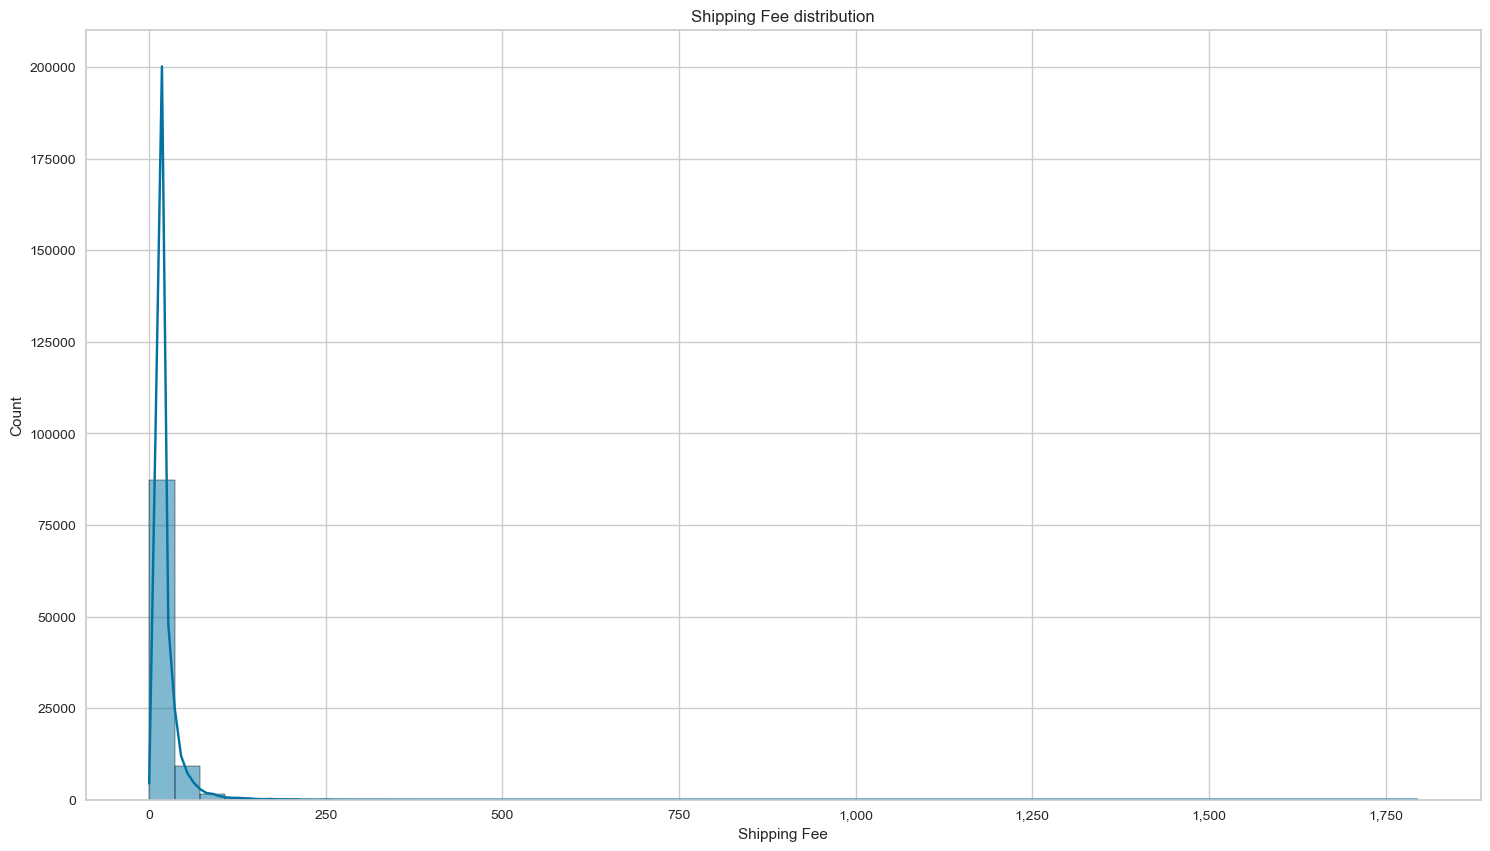

In [104]:
create_hist_plot(full_data,'Shipping Fee')

**Interpretation – `Shipping Fee`**

The `Shipping Fee` column represents the shipping cost associated with each transaction. The data contains **98,834 records**, and the column is of type `float64`. Here is a statistical summary:

- **Mean**: 22.06
- **Standard Deviatio**: 20.55
- **Minimum Shipping Fee**: 0.00
- **Maximum Shipping Fee**: 1,794.96
- **25th Percentile**: 13.55
- **50th Percentile (Median)**: 16.92
- **75th Percentile**: 23.31

From the **value count**, we observe the following shipping fees with notable frequencies:
- **15.10**: 2.96% of the records
- **7.78**: 1.87% of the records
- **14.10**: 1.52% of the records
- **11.85**: 1.48% of the records
- **18.23**: 1.24% of the records

- The **mean shipping fee** of 22.06 suggests that, on average, customers pay around this amount for shipping. However, the **standard deviation** of 20.55 indicates a significant variation, meaning that shipping fees vary widely across transactions.
- The **minimum shipping fee** of 0.00 might indicate free shipping offers or promotions.
- The **maximum shipping fee** of 1,794.96 is an outlier, which could point to premium shipping options, large orders, or a data issue that requires further validation.
 The **median shipping fee** of 16.92 suggests that half of the transactions have shipping fees below this value.

## 4) Bivariate analysis

### 4.1) Numerical vs numerical features (Correlation & scatter plots)

#### 4.1.1) Scatter plots

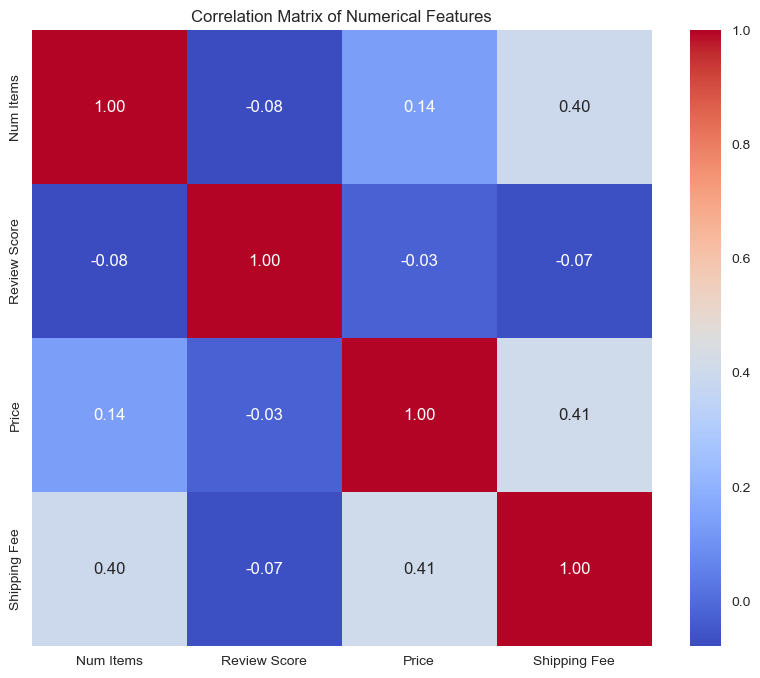

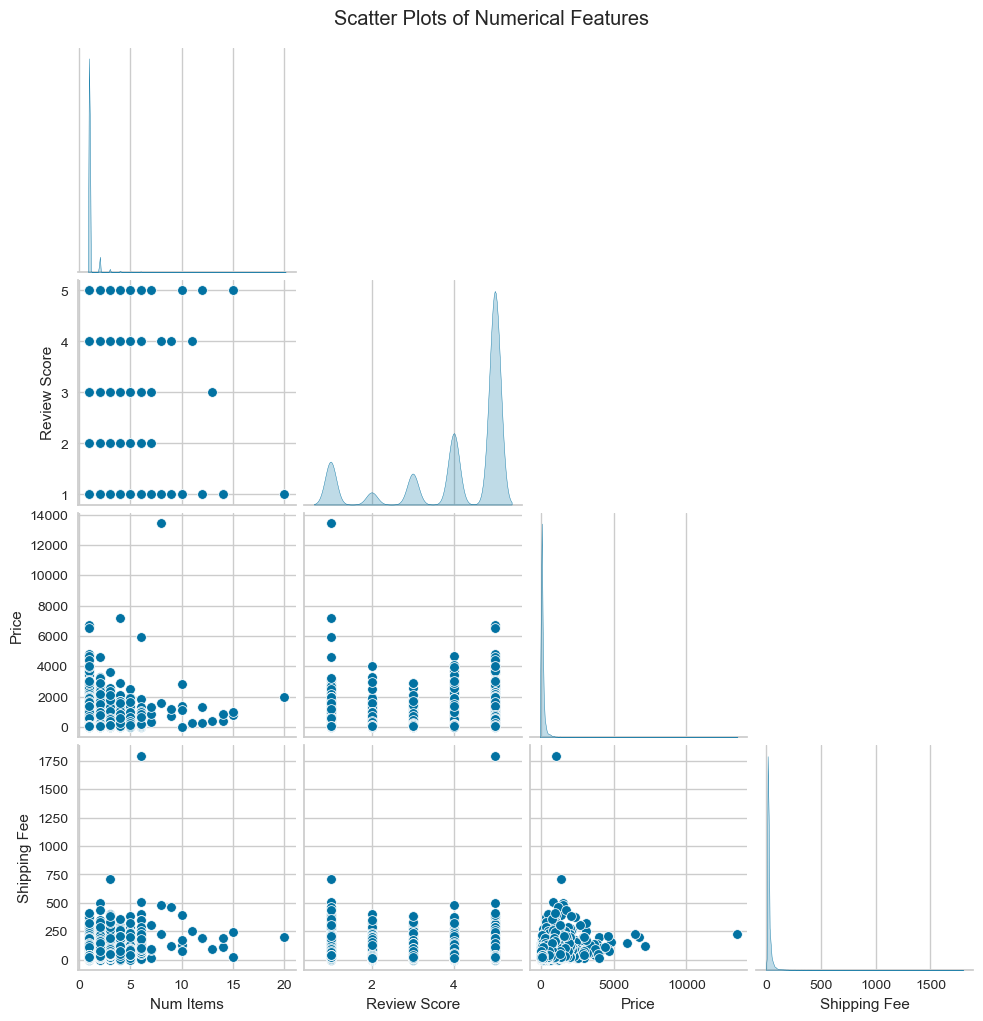

In [109]:
numerical_cols = [
    'Num Items', 'Review Score', 'Price', 'Shipping Fee'
]

plt.figure(figsize=(10, 8))
correlation_matrix = full_data[numerical_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

sns.pairplot(full_data[numerical_cols], diag_kind='kde', corner=True)
plt.suptitle('Scatter Plots of Numerical Features', y=1.02)
plt.show()


**Interpretation**

The correlation matrix above displays the pairwise Pearson correlation coefficients between the numerical features in the dataset:

- **Price vs Shipping Fee** has the **strongest positive correlation** (0.41), suggesting that higher-priced products tend to incur higher shipping fees.
- **Num Items vs Shipping Fee** shows a **moderate positive correlation** (0.40), which may imply that orders with more items have slightly higher shipping costs.
- **Review Score** has **very weak or negligible correlations** with all other features (coefficients around 0), indicating that customer satisfaction (as represented by review scores) is not linearly related to price, number of items, or shipping cost.
- No pair of features shows a high correlation (e.g., > 0.8), suggesting that **multicollinearity is not a concern** in this feature set.

### 4.2) Numerical vs categorical features (ANOVA)

In [112]:
import pandas as pd
from scipy.stats import f_oneway

results = []

numerical_cols = ['Num Items', 'Review Score', 'Price', 'Shipping Fee']
categorical_cols = [
    'Order Status', 'Customer City', 'Customer State', 'Product Category', 'Seller City', 'Seller State',
    'Payment Method', 'Used Voucher', 'Day', 'Month', 'Year'
]

for num_col in numerical_cols:
    for cat_col in categorical_cols:
        # Lấy dữ liệu con và loại bỏ NA
        sub_df = full_data[[num_col, cat_col]].dropna()
        
        # Gom nhóm theo categorical
        groups = [group[num_col].values for name, group in sub_df.groupby(cat_col)]
        
        # Chỉ tính ANOVA nếu có từ 2 nhóm trở lên
        if len(groups) >= 2:
            f_stat, p_val = f_oneway(*groups)
            results.append({
                'Numerical Column': num_col,
                'Categorical Column': cat_col,
                'p-value': round(p_val, 4),
                'Significant (p < 0.05)': p_val < 0.05
            })

# Hiển thị kết quả dưới dạng DataFrame
anova_results = pd.DataFrame(results)
print(anova_results)

   Numerical Column Categorical Column  p-value  Significant (p < 0.05)
0         Num Items       Order Status   0.0000                    True
1         Num Items      Customer City   1.0000                   False
2         Num Items     Customer State   0.0005                    True
3         Num Items   Product Category   0.0000                    True
4         Num Items        Seller City   0.0000                    True
5         Num Items       Seller State   0.0003                    True
6         Num Items     Payment Method   0.0000                    True
7         Num Items       Used Voucher   0.0027                    True
8         Num Items                Day   0.0072                    True
9         Num Items              Month   0.0000                    True
10        Num Items               Year   0.4643                   False
11     Review Score       Order Status   0.0000                    True
12     Review Score      Customer City   0.0000                 

This table summarizes the results of statistical tests (e.g., ANOVA or Kruskal-Wallis) assessing the relationship between numerical and categorical variables. A **p-value < 0.05** indicates a statistically significant relationship.

- **Num Items** shows significant relationships with most categorical variables including:
  - `Order Status`, `Product Category`, `Seller City`, `Seller State`, `Payment Method`, `Used Voucher`, `Day`, and `Month`.
  - No significant relationship with `Customer City` and `Year`.

- **Review Score** is significantly affected by almost all categorical features **except**:
  - `Used Voucher` and `Customer City`.

- **Price** is significantly associated with nearly **all categorical variables**, except `Year`.

- **Shipping Fee** is also significantly related to most categorical variables, except:
  - `Used Voucher`.

- Categorical features like `Order Status`, `Product Category`, `Payment Method`, and `Seller-related fields` tend to influence **all four** numerical features — making them strong candidates for further modeling or interaction term exploration.
- Temporal variables like `Year` tend not to have a significant effect on most numerical features.

## 5) Business findings from the EDA

**1. Order Fulfillment & Customer Experience**
- **Delivery Rate:** ~98% of orders delivered  
  - **Implication:** Strong logistics performance  
  - **Action:** Investigate the ~0.43% cancellations (e.g. stockouts, payment issues)

- **Rare Statuses (<0.01% “unavailable”/“approved”):**  
  - **Implication:** Possible data‐entry or system errors  
  - **Action:** Cleanse or validate before modeling; improve status tracking

---

**2. Geographic Concentration**
- **Top Customer Cities:**  
  1. São Paulo (15.7%)  
  2. Rio de Janeiro (6.8%)  
  3. Minas Gerais (11.7%)  
  - **Action:** Target marketing and promotions; consider additional logistics hubs

- **Seller Skew:** São Paulo accounts for 70.99% of sellers  
  - **Action:** Recruit sellers in emerging states to diversify supply and reduce delivery times

---

**3. Product & Category Insights**
- **Top Categories by Volume:**  
  1. bed_bath_table (10.1%)  
  2. health_beauty (9.0%)  
  3. sports_leisure (7.8%)  
  - **Action:** Prioritize inventory, promotions, and bundling strategies

- **Long-Tail Categories (<0.01%):**  
  - **Action:** Assess profitability or consider phasing out low-volume SKUs

---

**4. Payment & Promotions**
- **Payment Mix:** Credit Card (78.3%), Boleto (20.1%), Debit Card (1.6%)  
  - **Action:** Incentivize debit-card use; test installment plans

- **Voucher Usage:** Only 2.3% of orders  
  - **Action:** Expand/promote voucher campaigns, especially in lower-value segments

---

**5. Temporal Trends**
- **Peak Months:** August (11.0%), May (10.7%), July (10.4%)  
  - **Action:** Ramp up marketing and inventory ahead of peak seasons

- **Mid-Month Spike:** Days 15–24 (~10% of orders)  
  - **Action:** Schedule flash-sales or payday promotions around mid-month

---

**6. Order Composition & Spend**
- **Single-Item Orders:** 93% of all orders  
  - **Action:** Introduce “frequently bought together” bundles to increase AOV

- **Price & Shipping Variability:**  
  - Mean Price: 133.33 (σ=204.8)  
  - Mean Shipping: 22.06 (σ=20.55)  
  - **Action:** Review shipping fee policy; consider free shipping thresholds

---

**7. Customer Satisfaction Signals**
- **Average Review:** 4.08/5, but 11.6% are 1-star  
  - **Action:** Analyze 1-star reviews by category and region; address quality or service gaps

---

**8. Feature Relationships for Modeling**
- **Correlations:**  
  - Price ↔ Shipping Fee (r=0.41)  
  - Num Items ↔ Shipping Fee (r=0.40)  

- **Significant Categorical Drivers:** Order Status, Product Category, Seller Location, Payment Method  
  - **Action:** Use these features (and their interactions) in predictive models for cancellations, high-value orders, and satisfaction
 
---

**Next Steps**
1. **Pilot Voucher Campaigns** in under-penetrated regions  
2. **Audit Outliers:** Shipping fees & rare statuses  
3. **Model Development:** Build classification/regression models using identified drivers  

#  IV) Prepare the data

## 1) Transform to be done on each feature

**Feature Transformation Plan**

Below is a structured plan to transform and engineer features for modeling. It’s organized by feature type, with specific techniques and rationale.

| Feature                | Type         | Transformation                                              | Rationale / Notes                                 |
|------------------------|--------------|-------------------------------------------------------------|---------------------------------------------------|
| **Num Items**          | Numeric      | - Cap at 95th percentile (e.g. max=3)                       | Reduce influence of extreme bulk orders.          |
|                        |              | - Scale (RobustScaler)                                      | Handles outliers better than MinMax/Standard.     |
| **Review Score**       | Ordinal      | - Map 1–5 to [0–1]                                          | Preserve order; treat as continuous.              |
|                        |              | - Optionally bin (low:1–2, mid:3, high:4–5)                 | For tree-based models or imbalance correction.    |
| **Price**              | Numeric      | - Log1p transform                                           | Mitigate right skew.                              |
|                        |              | - Scale (StandardScaler)                                    | Standardize for distance-based models.            |
| **Shipping Fee**       | Numeric      | - Log1p transform                                           | Reduce skew from zero-fee and high outliers.      |
|                        |              | - Scale (RobustScaler)                                      | Robust to remaining extremes.                     |
| **Order Status**       | Categorical  | - Binary flag “Delivered” vs. “Not Delivered”               | Simplify target/outcome modeling.                 |
|                        |              | - One-hot encode remaining statuses (shipped, canceled…)    | Capture intermediate states if needed.            |
| **Customer State**     | Categorical  | - One-hot encode top 5 states by frequency                  | Capture main markets.                             |
|                        |              | - “Other” bucket for remaining states                       | Control dimensionality.                           |
| **Customer City**      | High-card.   | - Target-encode (mean target) or frequency-encode           | Avoid one-hot explosion.                          |
| **Seller State**       | Categorical  | - One-hot encode top 3 states                                | São Paulo, MG, PR.                                |
|                        |              | - “Other” bucket                                           |                                                   |
| **Seller City**        | High-card.   | - Frequency-encode                                        | Capture relative importance without too many dummies. |
| **Product Category**   | Categorical  | - One-hot encode top 10 categories                          | High-volume segments.                             |
|                        |              | - “Other” bucket                                           | Consolidate tail.                                 |
| **Payment Method**     | Categorical  | - One-hot encode (credit, boleto, debit)                    | Small number of levels.                           |
| **Used Voucher**       | Binary       | - Map “Yes”→1, “No”→0                                       | Ready for modeling.                               |
| **Day of Month**       | Temporal     | - Cyclical encode:  
  -  sin_day = sin(2π·day/31)  
  -  cos_day = cos(2π·day/31)                                 | Preserve circularity.                             |
| **Month**              | Temporal     | - Cyclical encode:  
  -  sin_month = sin(2π·month/12)  
  -  cos_month = cos(2π·month/12)                             | Capture seasonality.                              |
| **Year**               | Temporal     | - If all data in 2016–2018, map to ordinal [0,1,2] or drop | Low variance; may not add value.                  |

**Additional Engineered Features**
- **Price per Item:** `price / num_items` (after num_items > 0)  
  *Captures average unit price.*
- **Shipping Ratio:** `shipping_fee / price`  
  *Indicates relative shipping burden.*
- **High-Value Flag:** `price > p75` (75th percentile)  
  *Binary marker for premium orders.*
- **Weekend Indicator:** `is_weekend = month/day → weekday ∈ {Sat, Sun}`  
  *If day-of-week available via order date.*

---

> **Implementation Notes:**  
> 1. Fit encoders/scalers only on training data; apply to validation/test.  
> 2. Use cross-validation to evaluate impact of each transformation.  
> 3. Monitor feature importances to revisit rare-category grouping thresholds.  


## 3) Feature selection

### 3.1) Drop features

## 4) Feature engineering

In [122]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import RobustScaler, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd

# 1. Numeric Feature Transformers
class NumItemsTransformer(BaseEstimator, TransformerMixin):
    """
    Cap `Num Items` at the 95th percentile and apply RobustScaler.
    """
    def __init__(self):
        self.feature = 'Num Items'
        self.percentile = 95
        self.cap_value_ = None
        self.scaler_ = RobustScaler()

    def fit(self, X, y=None):
        self.cap_value_ = np.percentile(X[self.feature], self.percentile)
        capped_values = np.where(
            X[self.feature] > self.cap_value_, self.cap_value_, X[self.feature]
        )
        self.scaler_.fit(capped_values.reshape(-1, 1))
        return self

    def transform(self, X):
        X_copy = X.copy()
        # Cap values
        X_copy[self.feature] = np.where(
            X_copy[self.feature] > self.cap_value_, self.cap_value_, X_copy[self.feature]
        )
        # Scale values
        X_copy[self.feature] = self.scaler_.transform(X_copy[self.feature].values.reshape(-1, 1)).flatten()
        return X_copy

class PriceTransformer(BaseEstimator, TransformerMixin):
    """
    Apply log1p transform to `Price` and StandardScaler.
    """
    def __init__(self):
        self.feature = 'Price'
        self.scaler_ = StandardScaler()

    def fit(self, X, y=None):
        log_values = np.log1p(X[self.feature])
        self.scaler_.fit(log_values.values.reshape(-1, 1))
        return self

    def transform(self, X):
        X_copy = X.copy()
        # Log transform
        X_copy[self.feature] = np.log1p(X_copy[self.feature])
        # Scale values
        X_copy[self.feature] = self.scaler_.transform(X_copy[self.feature].values.reshape(-1, 1)).flatten()
        return X_copy

class ShippingFeeTransformer(BaseEstimator, TransformerMixin):
    """
    Apply log1p transform to `Shipping Fee` and RobustScaler.
    """
    def __init__(self):
        self.feature = 'Shipping Fee'
        self.scaler_ = RobustScaler()

    def fit(self, X, y=None):
        log_values = np.log1p(X[self.feature])
        self.scaler_.fit(log_values.values.reshape(-1, 1))
        return self

    def transform(self, X):
        X_copy = X.copy()
        # Log transform
        X_copy[self.feature] = np.log1p(X_copy[self.feature])
        # Scale values
        X_copy[self.feature] = self.scaler_.transform(X_copy[self.feature].values.reshape(-1, 1)).flatten()
        return X_copy

# 2. Ordinal Feature Transformers
class ReviewScoreTransformer(BaseEstimator, TransformerMixin):
    """
    Map review scores from [1-5] to [0-1].
    Optionally bin into low (1-2), mid (3), high (4-5).
    """
    def __init__(self, bin_scores=False):
        self.feature = 'Review Score'
        self.bin_scores = bin_scores

    def fit(self, X, y=None): 
        return self

    def transform(self, X):
        X_copy = X.copy()
        if self.bin_scores:
            # Create binned version (low:1-2, mid:3, high:4-5)
            bins = {1: 'low', 2: 'low', 3: 'mid', 4: 'high', 5: 'high'}
            X_copy[f'{self.feature}_bin'] = X_copy[self.feature].map(bins)
        else:
            # Map 1-5 to 0-1 range
            X_copy[self.feature] = (X_copy[self.feature] - 1) / 4
        return X_copy

# 3. Categorical Feature Transformers
class OrderStatusTransformer(BaseEstimator, TransformerMixin):
    """
    Binary flag for "Delivered" vs "Not Delivered" and one-hot encode all statuses.
    """
    def __init__(self):
        self.feature = 'Order Status'
        self.encoder_ = None
        self.categories_ = None

    def fit(self, X, y=None):
        self.encoder_ = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        self.encoder_.fit(X[self.feature].values.reshape(-1, 1))
        self.categories_ = self.encoder_.categories_[0]
        return self

    def transform(self, X):
        X_copy = X.copy()
        # Binary delivery flag
        X_copy['is_delivered'] = (X_copy[self.feature] == 'delivered').astype(int)
        
        # One-hot encode all statuses
        oh = self.encoder_.transform(X_copy[self.feature].values.reshape(-1, 1))
        
        # Add encoded columns directly to the dataframe
        for i, category in enumerate(self.categories_):
            X_copy[f"{self.feature}_{category}"] = oh[:, i]
        
        return X_copy

class CustomerStateTransformer(BaseEstimator, TransformerMixin):
    """
    One-hot encode top 5 frequent states and group others into 'Other'.
    """
    def __init__(self):
        self.feature = 'Customer State'
        self.top_k = 5
        self.top_states_ = None
        self.encoder_ = None
        self.categories_ = None

    def fit(self, X, y=None):
        self.top_states_ = X[self.feature].value_counts().nlargest(self.top_k).index.tolist()
        categories = self.top_states_ + ['Other']
        
        # Create a temporary series for fitting
        temp_series = X[self.feature].fillna('Other').copy()
        temp_series.loc[~temp_series.isin(self.top_states_)] = 'Other'
        
        self.encoder_ = OneHotEncoder(categories=[categories], handle_unknown='ignore', sparse_output=False)
        self.encoder_.fit(temp_series.values.reshape(-1, 1))
        self.categories_ = categories
        return self

    def transform(self, X):
        X_copy = X.copy()
        
        # Create a temporary series for transformation
        temp_series = X_copy[self.feature].fillna('Other').copy()
        temp_series.loc[~temp_series.isin(self.top_states_)] = 'Other'
        
        # Get one-hot encoded values
        oh = self.encoder_.transform(temp_series.values.reshape(-1, 1))
        
        # Add encoded columns directly to the dataframe
        for i, category in enumerate(self.categories_):
            X_copy[f"{self.feature}_{category}"] = oh[:, i]
        
        return X_copy

class CustomerCityTransformer(BaseEstimator, TransformerMixin):
    """
    Frequency encode high-cardinality city feature.
    """
    def __init__(self):
        self.feature = 'Customer City'
        self.freq_map_ = None

    def fit(self, X, y=None):
        self.freq_map_ = X[self.feature].value_counts(normalize=True)
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy[f'{self.feature}_freq'] = X_copy[self.feature].map(self.freq_map_).fillna(0)
        return X_copy

class SellerStateTransformer(BaseEstimator, TransformerMixin):
    """
    One-hot encode top 3 seller states (São Paulo, MG, PR) and group others.
    """
    def __init__(self):
        self.feature = 'Seller State'
        self.top_k = 3
        self.top_states_ = None
        self.encoder_ = None
        self.categories_ = None

    def fit(self, X, y=None):
        self.top_states_ = X[self.feature].value_counts().nlargest(self.top_k).index.tolist()
        categories = self.top_states_ + ['Other']
        
        # Create a temporary series for fitting
        temp_series = X[self.feature].fillna('Other').copy()
        temp_series.loc[~temp_series.isin(self.top_states_)] = 'Other'
        
        self.encoder_ = OneHotEncoder(categories=[categories], handle_unknown='ignore', sparse_output=False)
        self.encoder_.fit(temp_series.values.reshape(-1, 1))
        self.categories_ = categories
        return self

    def transform(self, X):
        X_copy = X.copy()
        
        # Create a temporary series for transformation
        temp_series = X_copy[self.feature].fillna('Other').copy()
        temp_series.loc[~temp_series.isin(self.top_states_)] = 'Other'
        
        # Get one-hot encoded values
        oh = self.encoder_.transform(temp_series.values.reshape(-1, 1))
        
        # Add encoded columns directly to the dataframe
        for i, category in enumerate(self.categories_):
            X_copy[f"{self.feature}_{category}"] = oh[:, i]
        
        return X_copy

class SellerCityTransformer(BaseEstimator, TransformerMixin):
    """
    Frequency encode high-cardinality seller city feature.
    """
    def __init__(self):
        self.feature = 'Seller City'
        self.freq_map_ = None

    def fit(self, X, y=None):
        self.freq_map_ = X[self.feature].value_counts(normalize=True)
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy[f'{self.feature}_freq'] = X_copy[self.feature].map(self.freq_map_).fillna(0)
        return X_copy

class ProductCategoryTransformer(BaseEstimator, TransformerMixin):
    """
    One-hot encode top 10 product categories and group others into 'Other'.
    """
    def __init__(self):
        self.feature = 'Product Category'
        self.top_k = 10
        self.top_categories_ = None
        self.encoder_ = None
        self.categories_ = None

    def fit(self, X, y=None):
        self.top_categories_ = X[self.feature].value_counts().nlargest(self.top_k).index.tolist()
        categories = self.top_categories_ + ['Other']
        
        # Create a temporary series for fitting
        temp_series = X[self.feature].fillna('Other').copy()
        temp_series.loc[~temp_series.isin(self.top_categories_)] = 'Other'
        
        self.encoder_ = OneHotEncoder(categories=[categories], handle_unknown='ignore', sparse_output=False)
        self.encoder_.fit(temp_series.values.reshape(-1, 1))
        self.categories_ = categories
        return self

    def transform(self, X):
        X_copy = X.copy()
        
        # Create a temporary series for transformation
        temp_series = X_copy[self.feature].fillna('Other').copy()
        temp_series.loc[~temp_series.isin(self.top_categories_)] = 'Other'
        
        # Get one-hot encoded values
        oh = self.encoder_.transform(temp_series.values.reshape(-1, 1))
        
        # Add encoded columns directly to the dataframe
        for i, category in enumerate(self.categories_):
            X_copy[f"{self.feature}_{category}"] = oh[:, i]
        
        return X_copy

class PaymentMethodTransformer(BaseEstimator, TransformerMixin):
    """
    One-hot encode payment methods (credit, boleto, debit).
    """
    def __init__(self):
        self.feature = 'Payment Method'
        self.encoder_ = None
        self.categories_ = None

    def fit(self, X, y=None):
        self.encoder_ = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        self.encoder_.fit(X[self.feature].values.reshape(-1, 1))
        self.categories_ = self.encoder_.categories_[0]
        return self

    def transform(self, X):
        X_copy = X.copy()
        
        # Get one-hot encoded values
        oh = self.encoder_.transform(X_copy[self.feature].values.reshape(-1, 1))
        
        # Add encoded columns directly to the dataframe
        for i, category in enumerate(self.categories_):
            X_copy[f"{self.feature}_{category}"] = oh[:, i]
        
        return X_copy

class UsedVoucherTransformer(BaseEstimator, TransformerMixin):
    """
    Map "Yes" -> 1, "No" -> 0 for Used Voucher.
    """
    def __init__(self):
        self.feature = 'Used Voucher'

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy[self.feature] = (X_copy[self.feature] == 'Yes').astype(int)
        return X_copy

# 4. Feature Engineering Transformers
class FeatureEngineeringTransformer(BaseEstimator, TransformerMixin):
    """
    Add engineered features:
    - price_per_item: Price / Num Items
    - shipping_ratio: Shipping Fee / Price
    - high_value_flag: Price > 75th percentile
    """
    def __init__(self):
        self.price_75th_ = None

    def fit(self, X, y=None):
        self.price_75th_ = np.percentile(X['Price'], 75)
        return self

    def transform(self, X):
        X_copy = X.copy()
        
        # Price per item
        X_copy['price_per_item'] = X_copy['Price'] / X_copy['Num Items'].replace(0, np.nan)
        
        # Shipping ratio
        X_copy['shipping_ratio'] = X_copy['Shipping Fee'] / X_copy['Price'].replace(0, np.nan)
        
        # High value flag
        X_copy['high_value_flag'] = (X_copy['Price'] > self.price_75th_).astype(int)
        
        # Fill NaNs
        X_copy = X_copy.fillna(0)
        
        return X_copy

# 5. Temporal Feature Transformers
class TemporalFeatureTransformer(BaseEstimator, TransformerMixin):
    """
    Extract and encode temporal features:
    - Cyclical encoding for day and month
    - Weekend indicator
    - Year ordinal encoding
    """
    def __init__(self):
        self.date_col = 'Purchase Time'
        self.year_mapping_ = None

    def fit(self, X, y=None):
        dates = pd.to_datetime(X[self.date_col], errors='coerce')
        years = dates.dt.year.dropna().unique()
        self.year_mapping_ = {year: idx for idx, year in enumerate(sorted(years))}
        return self

    def transform(self, X):
        X_copy = X.copy()
        dates = pd.to_datetime(X_copy[self.date_col], errors='coerce')
        
        # Extract basic components
        X_copy['Day'] = dates.dt.day
        X_copy['Month'] = dates.dt.month
        X_copy['Year'] = dates.dt.year
        
        # Cyclical encoding for day
        X_copy['Day_sin'] = np.sin(2 * np.pi * X_copy['Day'] / 31)
        X_copy['Day_cos'] = np.cos(2 * np.pi * X_copy['Day'] / 31)
        
        # Cyclical encoding for month
        X_copy['Month_sin'] = np.sin(2 * np.pi * X_copy['Month'] / 12)
        X_copy['Month_cos'] = np.cos(2 * np.pi * X_copy['Month'] / 12)
        
        # Weekend indicator
        X_copy['is_weekend'] = dates.dt.weekday.isin([5, 6]).astype(int)
        
        # Year ordinal encoding
        X_copy['Year_ord'] = X_copy['Year'].map(self.year_mapping_).fillna(-1)
        
        return X_copy

# 6. Feature Remover
class FeatureRemover(BaseEstimator, TransformerMixin):
    """
    Drop specified identifier columns not needed for modeling.
    """
    def __init__(self):
        self.features_to_drop = [
            'Order ID', 'Customer ID', 'Customer Unique ID', 
            'Product ID', 'Seller ID', 'Purchase Time'
        ]

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        missing = set(self.features_to_drop) - set(X_copy.columns)
        if missing:
            print(f"Warning: features not found for drop: {missing}")
        return X_copy.drop(columns=[f for f in self.features_to_drop if f in X_copy.columns], errors='ignore')

# Create a complete feature transformation pipeline
def create_feature_pipeline():
    """
    Create a full preprocessing pipeline for all features.
    """
    return Pipeline([
        # Numeric transformers
        ('num_items', NumItemsTransformer()),
        ('price', PriceTransformer()),
        ('shipping_fee', ShippingFeeTransformer()),
        
        # Ordinal transformers
        ('review_score', ReviewScoreTransformer(bin_scores=True)),
        
        # Categorical transformers
        ('order_status', OrderStatusTransformer()),
        ('customer_state', CustomerStateTransformer()),
        ('customer_city', CustomerCityTransformer()),
        ('seller_state', SellerStateTransformer()),
        ('seller_city', SellerCityTransformer()),
        ('product_category', ProductCategoryTransformer()),
        ('payment_method', PaymentMethodTransformer()),
        ('used_voucher', UsedVoucherTransformer()),
        
        # Feature engineering
        ('engineered_features', FeatureEngineeringTransformer()),
        
        # Temporal features
        ('temporal_features', TemporalFeatureTransformer()),
        
        # Remove identifier columns
        ('feature_remover', FeatureRemover())
    ])

# Example code to verify row count stays the same throughout pipeline
def verify_row_count(X):
    """
    Verify that the number of rows stays the same through each transformer.
    """
    pipeline = create_feature_pipeline()
    original_row_count = X.shape[0]
    print(f"Original row count: {original_row_count}")
    
    # Check each step in the pipeline
    temp_X = X.copy()
    for name, transformer in pipeline.steps:
        transformer.fit(temp_X)
        temp_X = transformer.transform(temp_X)
        current_row_count = temp_X.shape[0]
        print(f"After {name}: {current_row_count} rows")
        assert original_row_count == current_row_count, f"Row count changed at step {name}!"
    
    return "All steps maintain the same row count."

# Usage example
# pipeline = create_feature_pipeline()
# X_transformed = pipeline.fit_transform(X_train)
# verify_row_count(X_train)  # Verify row count doesn't change

## 5) Data Preprocessing

In [124]:
# Create a complete feature transformation pipeline
def create_feature_pipeline():
    """
    Create a full preprocessing pipeline for all features.
    """
    return Pipeline([
        # Numeric transformers
        ('num_items', NumItemsTransformer()),
        ('price', PriceTransformer()),
        ('shipping_fee', ShippingFeeTransformer()),
        
        # Ordinal transformers
        ('review_score', ReviewScoreTransformer(bin_scores=True)),
        
        # Categorical transformers
        ('order_status', OrderStatusTransformer()),
        ('customer_state', CustomerStateTransformer()),
        ('customer_city', CustomerCityTransformer()),
        ('seller_state', SellerStateTransformer()),
        ('seller_city', SellerCityTransformer()),
        ('product_category', ProductCategoryTransformer()),
        ('payment_method', PaymentMethodTransformer()),
        ('used_voucher', UsedVoucherTransformer()),
        
        # Feature engineering
        ('engineered_features', FeatureEngineeringTransformer()),
        
        # Temporal features
        ('temporal_features', TemporalFeatureTransformer()),
        
        # Remove identifier columns
        ('feature_remover', FeatureRemover())
    ])

# Usage example
# pipeline = create_feature_pipeline()
# X_transformed = pipeline.fit_transform(X_train)

# VII) Customer Segmentation

## 1) Data Preprocessing

In [127]:
pipeline = create_feature_pipeline()
train_data_seg = pipeline.fit_transform(full_data)

In [128]:
train_data_seg = train_data_seg.drop(columns=['Purchase Time'], errors='ignore')

train_data_seg = train_data_seg.drop(columns=train_data_seg.select_dtypes(include='object').columns)

In [129]:
train_data_seg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 98834 entries, 0 to 101760
Data columns (total 51 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Num Items                               98834 non-null  float64
 1   Price                                   98834 non-null  float64
 2   Shipping Fee                            98834 non-null  float64
 3   Used Voucher                            98834 non-null  int32  
 4   Review Score                            98834 non-null  int32  
 5   Day                                     98834 non-null  int32  
 6   Month                                   98834 non-null  int32  
 7   Year                                    98834 non-null  int32  
 8   is_delivered                            98834 non-null  int32  
 9   Order Status_approved                   98834 non-null  float64
 10  Order Status_canceled                   98834 non-null  float6

## 2) K-Means Clustering

In [131]:
X = np.asarray(train_data_seg)

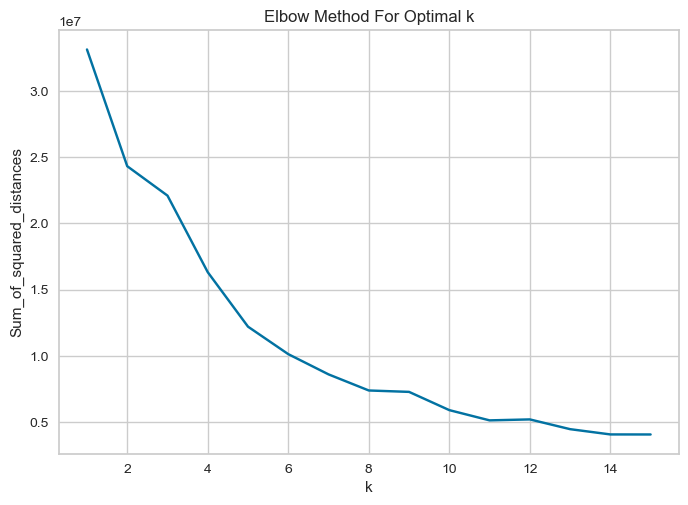

In [132]:
Sum_of_squared_distances = []
K = range(1,16)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [133]:
def kmeans(normalised_df_rfm, clusters_number, original_df_rfm):
    
    kmeans = KMeans(n_clusters = clusters_number, random_state = 1)
    kmeans.fit(normalised_df_rfm)

    # Extract cluster labels
    cluster_labels = kmeans.labels_
        
    # Create a cluster label column in original dataset
    df_new = original_df_rfm.assign(Cluster = cluster_labels)
    
    # Initialise TSNE
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df_new)
    
    # Plot t-SNE
    plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set1")
    
    return df_new

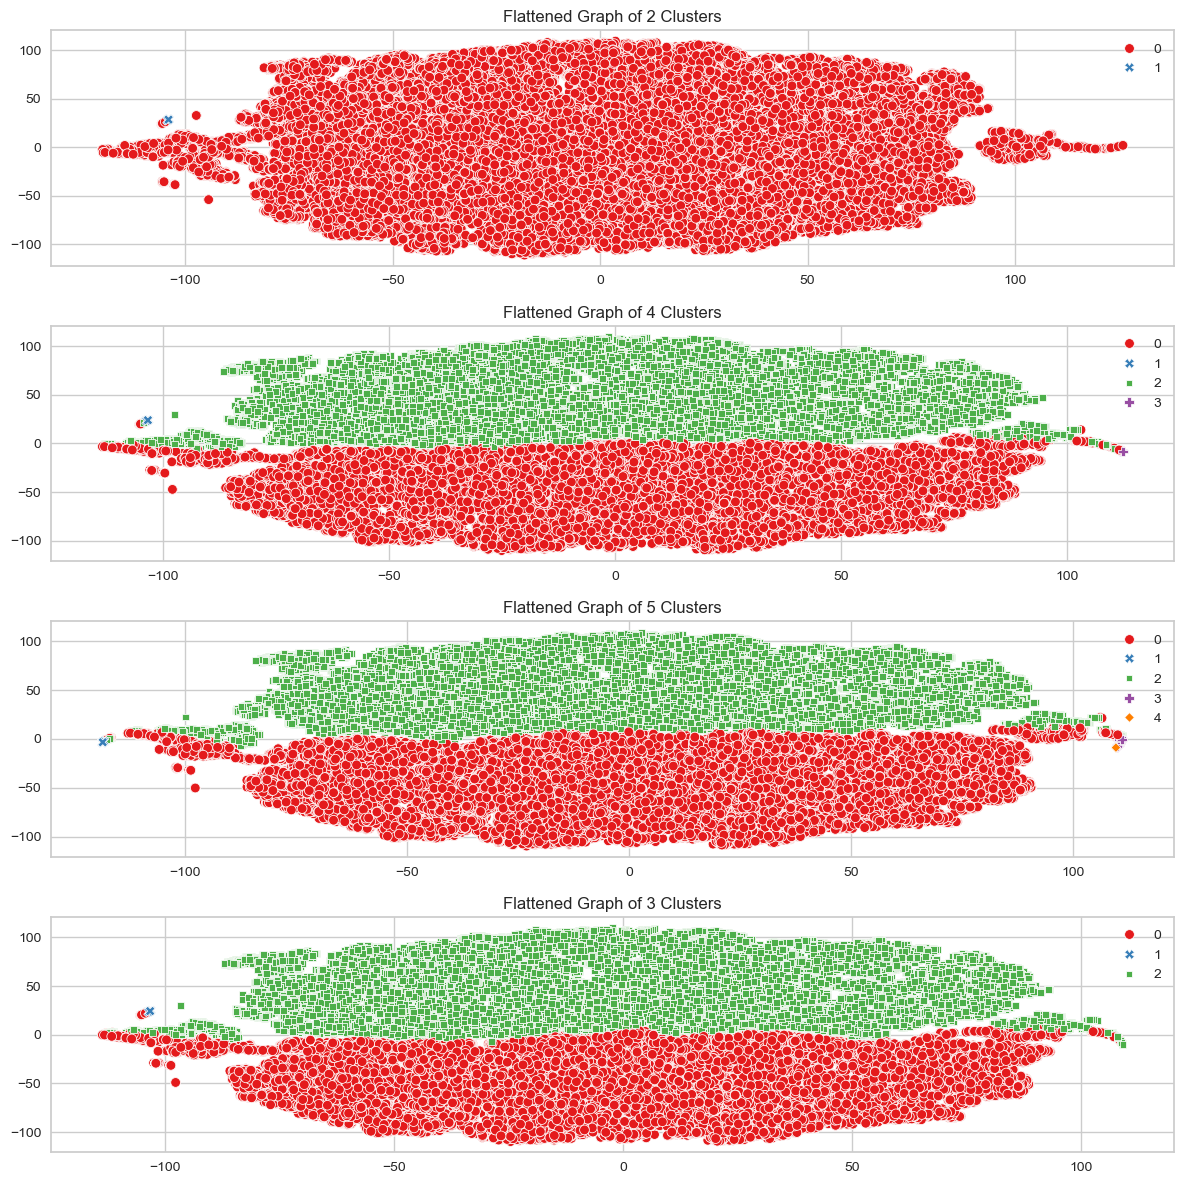

In [134]:
plt.figure(figsize=(12, 12))

# Subplot 1: K = 2
plt.subplot(4, 1, 1)
df_rfm_k2 = kmeans(train_data_seg, 2, train_data_seg)

# Subplot 2: K = 3
plt.subplot(4, 1, 4)
df_rfm_k3 = kmeans(train_data_seg, 3, train_data_seg)

# Subplot 3: K = 4
plt.subplot(4, 1, 2)
df_rfm_k4 = kmeans(train_data_seg, 4, train_data_seg)

# Subplot 4: K = 5
plt.subplot(4, 1, 3)
df_rfm_k5 = kmeans(train_data_seg, 5, train_data_seg)

plt.tight_layout()

## 3) Evaluating Model

In [238]:
for k in range(2, 6):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    score = davies_bouldin_score(X, kmeans.labels_)
    print(f'k = {k}, Davies-Bouldin Score = {score:.4f}')


k = 2, Davies-Bouldin Score = 0.3252
k = 3, Davies-Bouldin Score = 0.7682
k = 4, Davies-Bouldin Score = 0.6614
k = 5, Davies-Bouldin Score = 0.6441


**Clustering Evaluation using Davies-Bouldin Score**

| Number of Clusters (k) | Davies-Bouldin Score |
|------------------------|----------------------|
| 3                      | 0.7682               |
| 4                      | 0.6614               |
| 5                      | **0.6441**           |

**Analysis:**
- The **Davies-Bouldin Score (DBS)** measures cluster quality — **lower scores indicate better, more distinct clusters**.
- Among the tested values, **k = 5** yields the lowest DBS (**0.6441**), indicating the best clustering performance.
- From **k = 3 to k = 6**, the DBS increases, suggesting that clusters become less distinct and more overlapping.

**Conclusion:**  
**k = 5** appears to be the most appropriate number of clusters based on the Davies-Bouldin Score.

> **Tip:** Consider combining this with other metrics such as Silhouette Score or visualizing the clusters for more robust evaluation.


In [241]:
df_rfm_k5.head()

,Num Items,Price,Shipping Fee,Used Voucher,Review Score,Day,Month,Year,is_delivered,Order Status_approved,...,price_per_item,shipping_ratio,high_value_flag,Day_sin,Day_cos,Month_sin,Month_cos,is_weekend,Year_ord,Cluster
0,0.0,0.950182,0.366702,0,5,2,3,2018,1,0.0,...,0.0,0.385928,1,0.394356,0.918958,1.000000,6.123234e-17,0,2,0
1,0.0,0.399006,-0.150289,0,5,2,9,2017,1,0.0,...,0.0,-0.376660,0,0.394356,0.918958,-1.000000,-1.836970e-16,1,1,0
2,0.0,-0.790661,0.152642,0,5,2,7,2018,1,0.0,...,0.0,-0.193056,0,0.394356,0.918958,-0.500000,-8.660254e-01,0,2,0
3,0.0,2.660313,2.829263,0,4,28,1,2018,1,0.0,...,0.0,1.063507,1,-0.571268,0.820763,0.500000,8.660254e-01,1,2,2
4,0.0,0.037061,0.601541,0,5,20,8,2018,1,0.0,...,0.0,16.231083,0,-0.790776,-0.612106,-0.866025,-5.000000e-01,0,2,2


In [243]:
df_rfm_k5.info()

<class 'pandas.core.frame.DataFrame'>
Index: 98834 entries, 0 to 101760
Data columns (total 52 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Num Items                               98834 non-null  float64
 1   Price                                   98834 non-null  float64
 2   Shipping Fee                            98834 non-null  float64
 3   Used Voucher                            98834 non-null  int32  
 4   Review Score                            98834 non-null  int32  
 5   Day                                     98834 non-null  int32  
 6   Month                                   98834 non-null  int32  
 7   Year                                    98834 non-null  int32  
 8   is_delivered                            98834 non-null  int32  
 9   Order Status_approved                   98834 non-null  float64
 10  Order Status_canceled                   98834 non-null  float6

In [245]:
test = full_data.copy()

In [247]:
test.loc[df_rfm_k5.index, 'Cluster'] = df_rfm_k5['Cluster']
test['Cluster'] = test['Cluster'].astype('int32')
test.head()


,Order ID,Purchase Time,Order Status,Customer ID,Customer Unique ID,Customer City,Customer State,Product ID,Product Category,Num Items,...,Seller ID,Seller City,Seller State,Payment Method,Used Voucher,Review Score,Day,Month,Year,Cluster
0,50ba38c4dc467baab1ea2c8c7747934d,2018-03-02 21:32:44,delivered,9e01f714a2b3b8962c222cf2b74c20dc,e1feae9083c4c2895ddf6dc80526a85d,abadia dos dourados,MG,418d480693f2f01e9cf4568db0346d28,cool_stuff,1,...,12b9676b00f60f3b700e83af21824c0e,montenegro,RS,credit_card,No,5,2,3,2018,0
1,d99e6849f7676dade195f20c26f0eb4f,2017-09-02 22:37:17,delivered,a23e3f9a2b656b23b7e52075964b42cd,afddf43a03a9941624ed42c0b2c17280,abadia dos dourados,MG,1081ae52311daac87fb54ba8ce4670ac,sports_leisure,1,...,4371b634e0efc0e22b09b52907d9d469,sao paulo,SP,credit_card,No,5,2,9,2017,0
2,0a9a43ac5fe59c6c4bee2a8f9b9fcce8,2018-07-02 08:00:35,delivered,f11eb8f0b8b87510a93e3e1aa10b0ade,64ee476500a01beb94df40f97a108c50,abadia dos dourados,MG,c1aabbb6f4caec9f5bf7cd80519d6cc0,books_general_interest,1,...,579891617139df7d8671d373f0669622,rio de janeiro,RJ,boleto,No,5,2,7,2018,0
3,3f1294f87d79b57f5d55ba7b80c3d94f,2018-01-28 14:21:58,delivered,576d71ddb21b21763cfedce73b902180,8d76b559181609308fcae630ea64cd61,abadiania,GO,0a9b9a871ffaec6c0198334558a6c6a1,small_appliances,1,...,f9244d45189d3a3605499abddeade7d5,sao paulo,SP,credit_card,No,4,28,1,2018,2
4,5525ea8ee9e6150faa9b41dfc4024552,2018-08-20 21:33:48,delivered,08528824266cd0720658ff01df662b6a,8f7f547488a05660770b51be707eb2a3,abaete,MG,3354a4e684f5e7199f9407db70ccd92b,cool_stuff,1,...,7a67c85e85bb2ce8582c35f2203ad736,sao paulo,SP,credit_card,No,5,20,8,2018,2


In [249]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 98834 entries, 0 to 101760
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Order ID            98834 non-null  object        
 1   Purchase Time       98834 non-null  datetime64[ns]
 2   Order Status        98834 non-null  object        
 3   Customer ID         98834 non-null  object        
 4   Customer Unique ID  98834 non-null  object        
 5   Customer City       98834 non-null  object        
 6   Customer State      98834 non-null  object        
 7   Product ID          98834 non-null  object        
 8   Product Category    98834 non-null  object        
 9   Num Items           98834 non-null  int64         
 10  Price               98834 non-null  float64       
 11  Shipping Fee        98834 non-null  float64       
 12  Seller ID           98834 non-null  object        
 13  Seller City         98834 non-null  object        

Number of records per Cluster:
 Cluster
0    52791
1       43
2    45853
3      129
4       18
Name: count, dtype: int64

 Average of numerical features by Cluster:
         Num Items       Price  Shipping Fee  Review Score        Day  \
Cluster                                                                 
0         1.095698  135.316643     22.296032      4.075657   8.560323   
1         1.046512   83.097674     23.468605      3.930233  16.744186   
2         1.104900  131.249756     21.788810      4.082808  23.539114   
3         1.271318   83.080233     25.002713      4.131783  17.170543   
4         1.055556   83.080000     16.655000      3.166667  19.388889   

            Month         Year  
Cluster                         
0        6.027959  2017.561895  
1        5.162791  2017.720930  
2        6.052472  2017.522081  
3        6.255814  2017.612403  
4        5.111111  2017.333333  


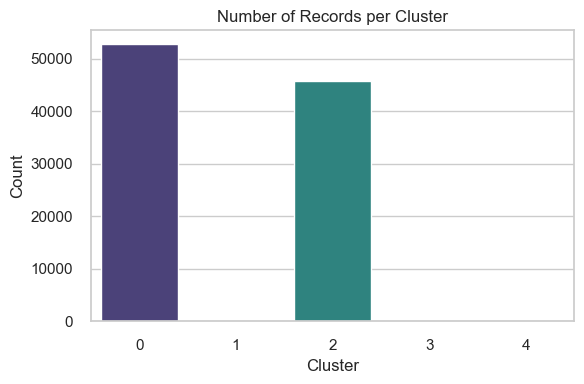

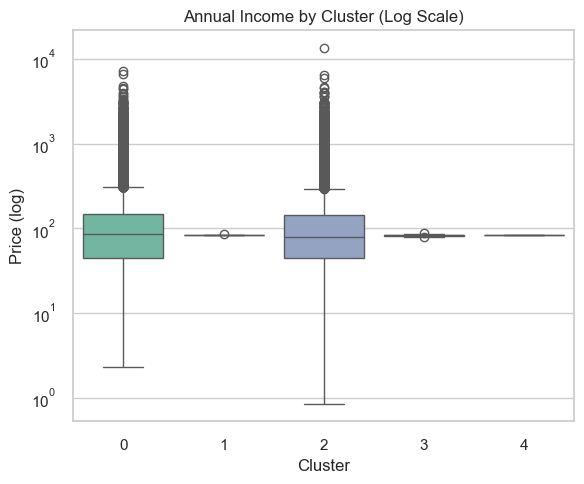

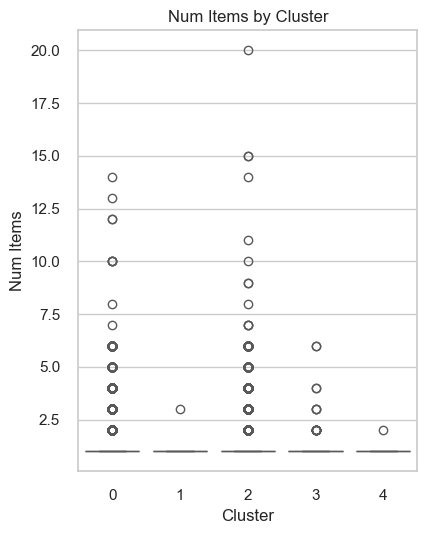

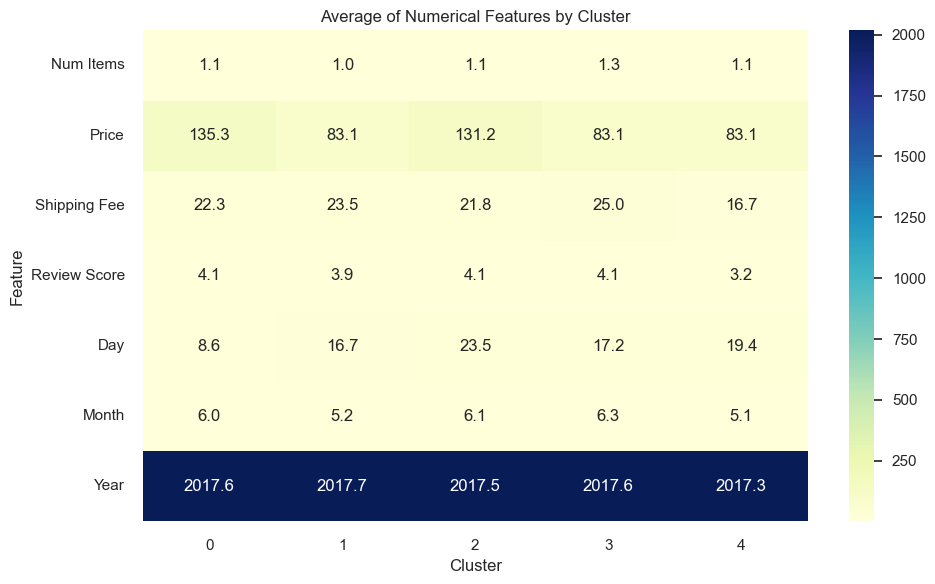

In [261]:
sns.set(style="whitegrid")

cluster_counts = test['Cluster'].value_counts().sort_index()
print("Number of records per Cluster:\n", cluster_counts)

print("\n Average of numerical features by Cluster:")
print(test.groupby('Cluster').mean(numeric_only=True))

cluster_stats = test.groupby('Cluster').agg(['mean', 'std', 'min', 'max'])
print("\nDetailed cluster statistics:\n", cluster_stats)

plt.figure(figsize=(6, 4))
sns.countplot(data=test, x='Cluster', palette='viridis')
plt.title('Number of Records per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 5))
sns.boxplot(data=test, x='Cluster', y='Price', palette='Set2')
plt.yscale('log')  # Log scale
plt.title('Annual Income by Cluster (Log Scale)')
plt.xlabel('Cluster')
plt.ylabel('Price (log)')
plt.tight_layout()
plt.show()

plt.subplot(1, 2, 2)
sns.boxplot(data=test, x='Cluster', y='Num Items', palette='Set2')
plt.title('Num Items by Cluster')

plt.tight_layout()
plt.show()

cluster_mean = test.groupby('Cluster').mean(numeric_only=True)

plt.figure(figsize=(10, 6))
sns.heatmap(cluster_mean.T, annot=True, fmt=".1f", cmap='YlGnBu')
plt.title('Average of Numerical Features by Cluster')
plt.ylabel('Feature')
plt.xlabel('Cluster')
plt.tight_layout()
plt.show()

## 4) Recommendation

**Summary of Evaluation and Recommendations for 5 Customer Clusters**

**1. Cluster Sizes**  
- **Clusters 0 & 2:** Largest (≈92% of data) – represent core purchasing behavior  
- **Clusters 1, 3 & 4:** Very small (≈0.3%) – likely outliers or highly niche segments

**2. Average Feature Values & Key Insights**  
| Cluster | Avg. Price | Avg. Shipping Fee | Avg. Review Score | Avg. Num Items | Key Observation                                   |
|---------|------------|-------------------|-------------------|----------------|---------------------------------------------------|
| 0       | 135.32     | 22.30             | 4.08              | 1.10           | Core, high spenders with strong satisfaction      |
| 1       | 83.10      | 23.47             | 3.93              | 1.05           | Low spenders, moderate satisfaction, single items |
| 2       | 131.25     | 21.79             | 4.08              | 1.10           | Similar to Cluster 0 but with slightly lower fees |
| 3       | 83.08      | 25.00             | 4.13              | 1.27           | Bulk buyers, highest satisfaction                 |
| 4       | 83.08      | 16.66             | 3.17              | 1.06           | Low spenders with low satisfaction                |

**3. Strategy Recommendations**  
| Cluster | Suggested Label        | Main Strategy                                                                 |
|---------|------------------------|--------------------------------------------------------------------------------|
| 0       | High-Value Core A      | VIP perks, loyalty points, premium cross-sell offers                           |
| 1       | Bargain Loyalists      | Discount coupons, small bundles, flash sale reminders                          |
| 2       | High-Value Core B      | Free-shipping incentives, referral rewards, milestone gifting                  |
| 3       | Bulk-Happy Shoppers    | Bulk discounts, combo suggestions, quantity-based rewards                      |
| 4       | Dissatisfied Minis     | Satisfaction surveys, refunds/vouchers, proactive follow-up                    |

> **Overall Recommendations:**  
> - Consider reducing **k** to **2–3** for a clear “core vs. outlier” segmentation.  
> - If retaining **k=5**, treat Clusters 1, 3, 4 primarily as **anomaly detectors**.  
> - Use A/B testing, PCA/t-SNE visualization, and adjust feature scaling (log/robust) for further refinement.  


# VIII) Save final dataset

In [253]:
df = df_result.copy()
df = df.dropna()
df.loc[df_rfm_k5.index, 'Cluster'] = df_rfm_k5['Cluster']
df['Cluster'] = df['Cluster'].astype('int32')
df.head()

,Order ID,Purchase Time,Order Status,Customer ID,Customer Unique ID,Customer City,Customer State,Product ID,Product Category,Num Items,Price,Shipping Fee,Seller ID,Seller City,Seller State,Payment Method,Used Voucher,Review Score,Cluster
0,50ba38c4dc467baab1ea2c8c7747934d,2018-03-02 21:32:44,delivered,9e01f714a2b3b8962c222cf2b74c20dc,e1feae9083c4c2895ddf6dc80526a85d,abadia dos dourados,MG,418d480693f2f01e9cf4568db0346d28,cool_stuff,1,199.00,20.63,12b9676b00f60f3b700e83af21824c0e,montenegro,RS,credit_card,No,5.0,0
1,d99e6849f7676dade195f20c26f0eb4f,2017-09-02 22:37:17,delivered,a23e3f9a2b656b23b7e52075964b42cd,afddf43a03a9941624ed42c0b2c17280,abadia dos dourados,MG,1081ae52311daac87fb54ba8ce4670ac,sports_leisure,1,120.00,15.59,4371b634e0efc0e22b09b52907d9d469,sao paulo,SP,credit_card,No,5.0,0
2,0a9a43ac5fe59c6c4bee2a8f9b9fcce8,2018-07-02 08:00:35,delivered,f11eb8f0b8b87510a93e3e1aa10b0ade,64ee476500a01beb94df40f97a108c50,abadia dos dourados,MG,c1aabbb6f4caec9f5bf7cd80519d6cc0,books_general_interest,1,39.90,18.38,579891617139df7d8671d373f0669622,rio de janeiro,RJ,boleto,No,5.0,0
3,3f1294f87d79b57f5d55ba7b80c3d94f,2018-01-28 14:21:58,delivered,576d71ddb21b21763cfedce73b902180,8d76b559181609308fcae630ea64cd61,abadiania,GO,0a9b9a871ffaec6c0198334558a6c6a1,small_appliances,1,949.99,75.53,f9244d45189d3a3605499abddeade7d5,sao paulo,SP,credit_card,No,4.0,2
4,5525ea8ee9e6150faa9b41dfc4024552,2018-08-20 21:33:48,delivered,08528824266cd0720658ff01df662b6a,8f7f547488a05660770b51be707eb2a3,abaete,MG,3354a4e684f5e7199f9407db70ccd92b,cool_stuff,1,85.99,23.40,7a67c85e85bb2ce8582c35f2203ad736,sao paulo,SP,credit_card,No,5.0,2


In [255]:
df.to_csv('segment_dataset.csv', index = False)